# Do Not Overfit Challenge

#### Kaggle recently launched a challenge to run classification models on datasets with a very particular goal - do not overfit!!

#### Datasets had only 250 rows and features around 320. Since our number of independent features is greater than sample size, we are faced with a very pressing overfitting challenge.

##### Below I enumerate the methodology to reduce overfitting :

###### 1. Reduce feature size using two specific techniques: pearsons  correlation coefficient and dimensionality reduction techniques
###### 2. Create handful of samples with goal on simplicity. eg less number of estimators,less number of iterations etc
###### 3. Provide regularization parameters where applicable
###### 4. Plot precision-recall curves and roc-auc curves for each model. Check learning curve as well.
###### 5. Use StratifiedKFold cross validation to parameter tune
###### 6. Deal with imbalance in target classes using under sampling and over sampling techniques



Note: baseline model creation(using all features + regularization + tsne dimensionality reduction + over/under sampling) technique provided no real use. CV scores for roc auc did not exceed 0.6 in every scenario possible.






In [1]:
import numpy as np
import pandas as panda
from matplotlib import pyplot as plot
import seaborn as sns

import pandas as panda
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,label_binarize

from sklearn.model_selection import train_test_split,KFold,\
    StratifiedKFold,GridSearchCV,RepeatedStratifiedKFold,learning_curve, cross_val_score

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, \
        classification_report,confusion_matrix,average_precision_score
from sklearn.linear_model import Perceptron, LogisticRegression,RidgeClassifier,SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plot
from itertools import cycle
import numpy as np 
from scipy import interp
import seaborn as sns
import itertools, time, datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif,f_classif,SelectKBest,chi2
from numpy import bincount, linspace, mean, std, arange, squeeze

import warnings

warnings.simplefilter('ignore')
%matplotlib inline


In [2]:
np.random.seed(143)

In [3]:
train_data = panda.read_csv('data/train.csv')


In [4]:
train_data.target.value_counts(), train_data.shape

(1.0    160
 0.0     90
 Name: target, dtype: int64, (250, 302))

In [5]:
train_data['target'] = train_data.target.astype(np.int64)

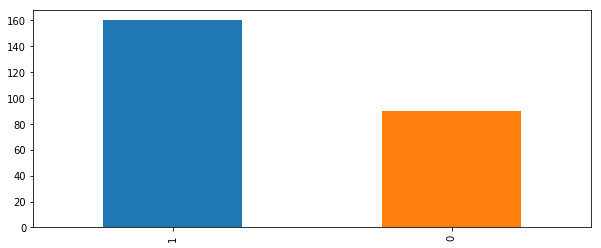

In [6]:
plot.figure(figsize=(10,4))
train_data.target.value_counts().plot(kind='bar')
plot.show()

In [7]:
train_data[[i for i in train_data.columns.tolist() if i not in ['target','id']]].describe(include='all').T

count      mean       std    min      25%     50%      75%    max
0    250.0  0.023292  0.998354 -2.319 -0.64475 -0.0155  0.67700  2.567
1    250.0 -0.026872  1.009314 -2.931 -0.73975  0.0570  0.62075  2.419
2    250.0  0.167404  1.021709 -2.477 -0.42525  0.1840  0.80500  3.392
3    250.0  0.001904  1.011751 -2.359 -0.68650 -0.0165  0.72000  2.771
4    250.0  0.001588  1.035411 -2.566 -0.65900 -0.0230  0.73500  2.901
5    250.0 -0.007304  0.955700 -2.845 -0.64375  0.0375  0.66050  2.793
6    250.0  0.032052  1.006657 -2.976 -0.67500  0.0605  0.78325  2.546
7    250.0  0.078412  0.939731 -3.444 -0.55075  0.1835  0.76625  2.846
8    250.0 -0.036920  0.963688 -2.768 -0.68950 -0.0125  0.63500  2.512
9    250.0  0.035448  1.019689 -2.361 -0.64350  0.0520  0.73300  2.959
10   250.0 -0.005032  1.085089 -3.302 -0.69350  0.0660  0.69425  3.271
11   250.0  0.110248  1.036265 -2.851 -0.52400  0.1155  0.78625  2.998
12   250.0  0.019808  1.050041 -2.681 -0.70850  0.0900  0.80525  2.729
13   250.0 -0.001108  1.024305 -2.596 -0.69200  0.0160  0.65400  2.651
14   250.0 -0.016280  0.926789 -3.275 -0.67700  0.0095  0.61100  2.913
15   250.0 -0.039644  0.955915 -3.512 -0.63450  0.0100  0.57800  2.508
16   250.0  0.017260  1.025655 -2.476 -0.68350 -0.1190  0.69900  3.286
17   250.0 -0.106856  1.012777 -3.619 -0.80150 -0.1645  0.49650  2.430
18   250.0  0.036184  0.945099 -2.428 -0.57425 -0.0095  0.68600  2.557
19   250.0 -0.043296  1.055935 -3.229 -0.75800 -0.0180  0.69800  2.868
20   250.0 -0.110832  1.003178 -3.024 -0.87050 -0.1615  0.56050  2.703
21   250.0  0.072680  1.039556 -2.775 -0.59600  0.0480  0.79700  2.691
22   250.0  0.017296  0.988482 -2.962 -0.72575  0.1350  0.63150  2.604
23   250.0 -0.030728  0.945902 -2.490 -0.65200 -0.0160  0.61925  2.362
24   250.0 -0.128252  0.997026 -3.107 -0.77950 -0.1655  0.57925  2.927
25   250.0  0.154736  0.997894 -2.943 -0.42425  0.1255  0.71950  2.976
26   250.0  0.083408  1.040371 -2.933 -0.58575  0.0365  0.79825  2.581
27   250.0  0.039552  0.922270 -2.942 -0.62500  0.0450  0.72175  2.305
28   250.0 -0.091784  1.047282 -2.957 -0.75125 -0.0260  0.67850  2.489
29   250.0  0.054636  1.041432 -2.911 -0.58250  0.0450  0.72875  2.895
..     ...       ...       ...    ...      ...     ...      ...    ...
270  250.0 -0.066236  0.985451 -2.448 -0.78675 -0.1010  0.52575  3.753
271  250.0 -0.057988  0.951879 -2.771 -0.70100 -0.1090  0.61200  2.498
272  250.0  0.091556  1.027877 -2.903 -0.54325  0.0505  0.86400  2.725
273  250.0 -0.029896  0.966882 -2.522 -0.67275 -0.0815  0.63025  2.680
274  250.0  0.115648  1.037173 -2.759 -0.62675  0.0875  0.83675  3.445
275  250.0  0.007372  1.004543 -2.915 -0.73025  0.0350  0.71800  2.846
276  250.0  0.033552  1.006219 -2.618 -0.64975  0.0865  0.79150  2.315
277  250.0  0.090524  1.037119 -3.623 -0.58950  0.1265  0.72600  2.780
278  250.0  0.001576  1.024067 -2.673 -0.72575  0.0535  0.68800  2.364
279  250.0 -0.007784  1.056086 -3.229 -0.66775  0.0635  0.66575  2.908
280  250.0  0.043184  1.012516 -2.537 -0.60500  0.0525  0.60375  2.926
281  250.0  0.082696  1.068741 -2.748 -0.63775  0.1030  0.70550  3.441
282  250.0  0.098476  0.934163 -2.850 -0.45825  0.1355  0.68825  2.319
283  250.0  0.055356  0.988100 -2.577 -0.55350  0.0390  0.75900  2.842
284  250.0  0.111708  1.043230 -2.973 -0.56675  0.0935  0.70475  3.343
285  250.0 -0.015688  1.010720 -2.709 -0.77825  0.0145  0.67375  3.266
286  250.0  0.035992  1.058982 -3.605 -0.69325 -0.0075  0.74875  3.061
287  250.0  0.026452  0.896318 -2.357 -0.59675  0.0005  0.60425  2.146
288  250.0 -0.059152  1.113760 -2.904 -0.78900 -0.1225  0.65050  2.853
289  250.0  0.077272  0.972530 -2.734 -0.67125  0.0575  0.77250  3.026
290  250.0  0.044652  1.011416 -2.804 -0.61700  0.0675  0.79725  2.865
291  250.0  0.126344  0.972567 -2.443 -0.51050  0.0910  0.80425  2.801
292  250.0  0.018436  0.954229 -2.757 -0.53575  0.0575  0.63150  2.736
293  250.0 -0.012092  0.960630 -2.466 -0.65700 -0.0210  0.65025  2.596
294  250.0 -0.065720  1.05741

In [8]:
data_type = train_data.dtypes.to_frame().reset_index()
data_type.columns  = ['col_name','col_type']
data_type[data_type.col_type==np.object].head()

Empty DataFrame
Columns: [col_name, col_type]
Index: []

In [9]:
train_data.isnull().any().sum()

0

In [10]:
col_names = [i for i in train_data.columns if i not in ['target','id']]

In [11]:
def draw_relevant_plots(table, columns):
    
    
    fig, axes = plot.subplots(1, 5, figsize=(10, 7), sharex=True)
    count = 0
    for col in columns:
        
        ax = axes[count]
        sns.distplot(table[col], ax = axes[count])
        
        count+= 1
    plot.show()  
    
    plot.figure(figsize = (10,4))
    data = table[columns]
    data = panda.concat([data,table['target']], axis = 1)
    correlation_map = np.corrcoef(data.values.T)
    sns.heatmap(correlation_map,
                cbar = True,
                annot=True,
                square = True,
                fmt = '.2f',
                annot_kws = {'size':15},
                yticklabels = data.columns.tolist(),
                xticklabels = data.columns.tolist(),
               )
    plot.show()
        

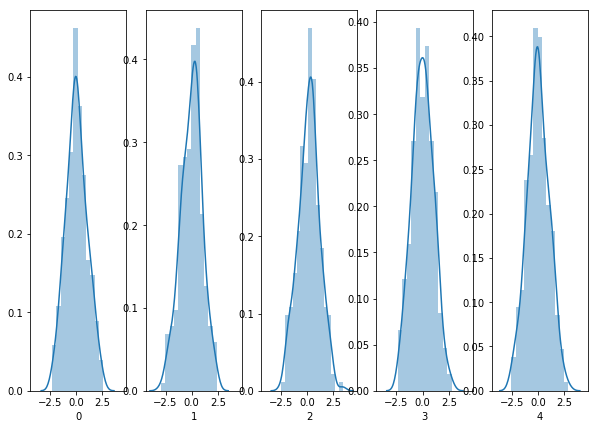

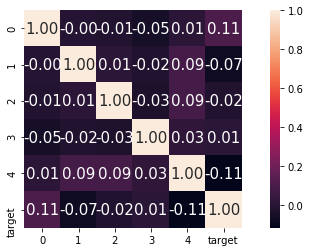

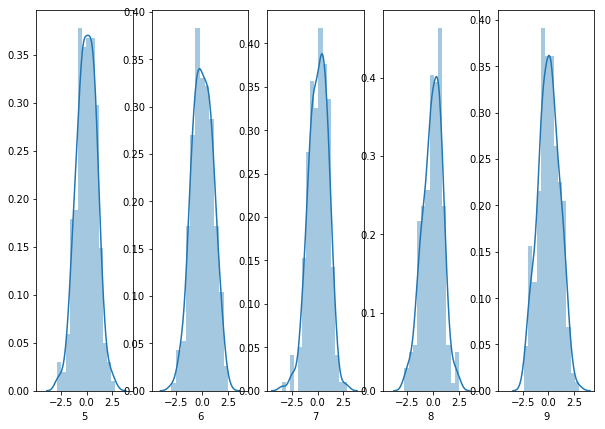

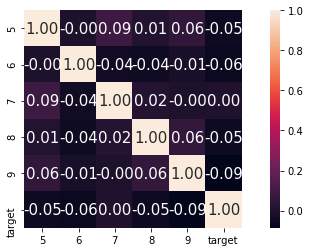

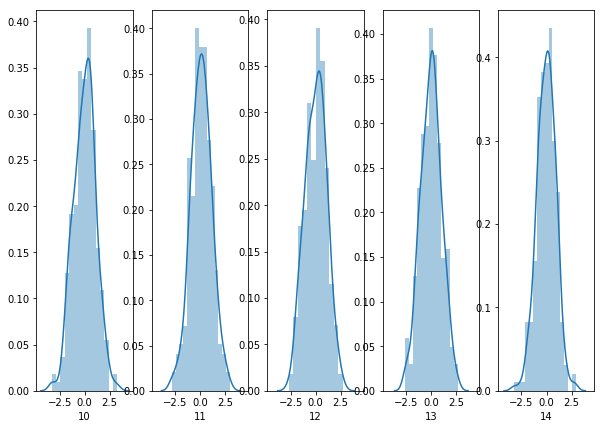

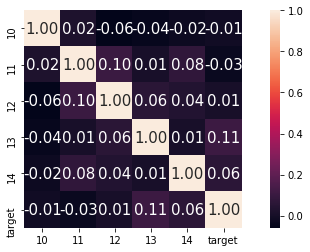

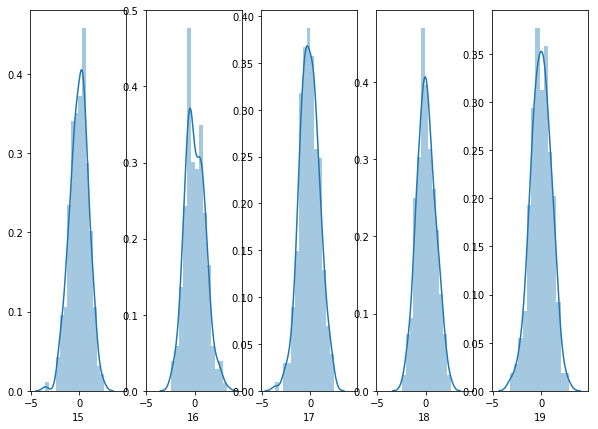

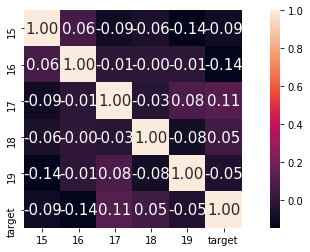

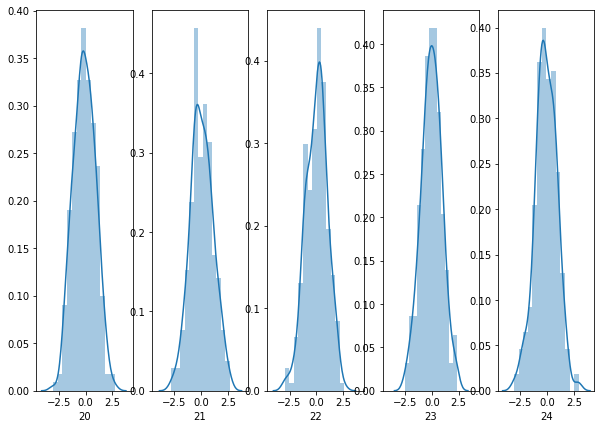

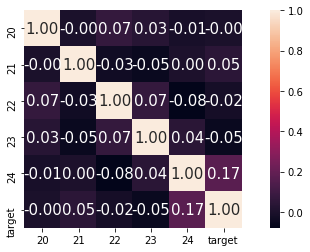

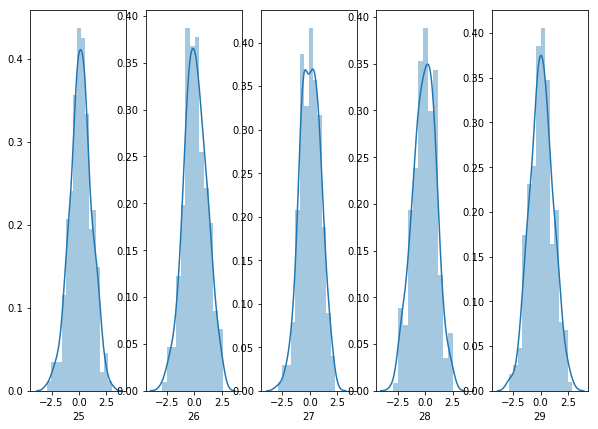

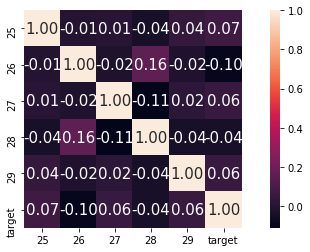

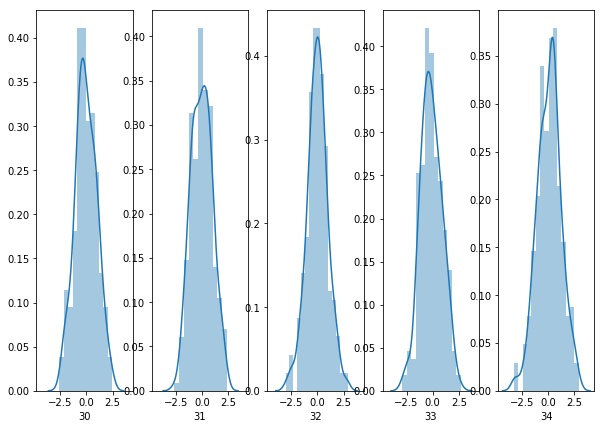

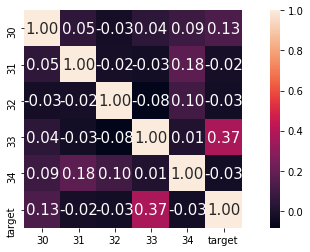

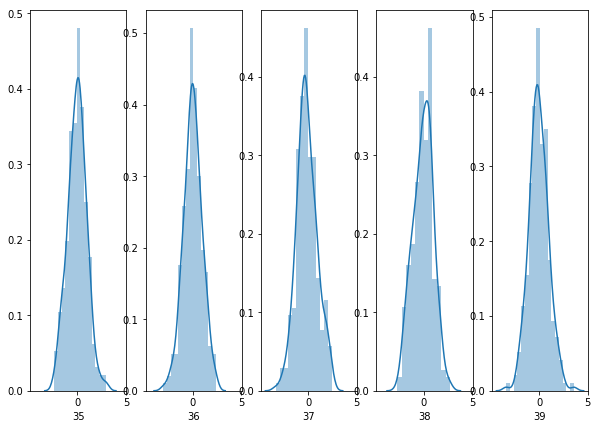

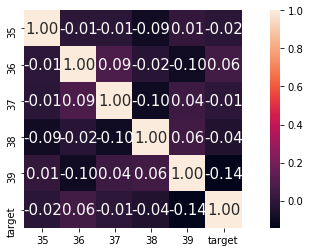

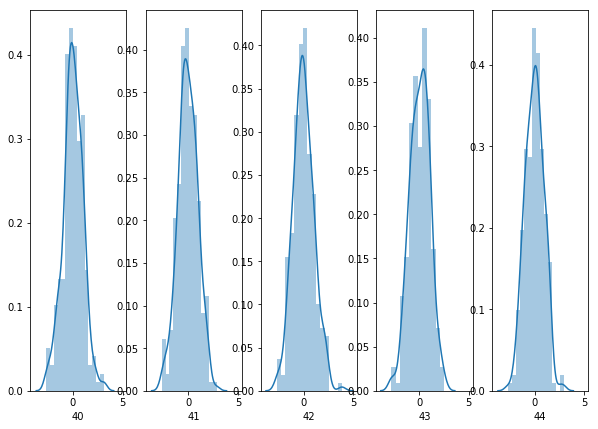

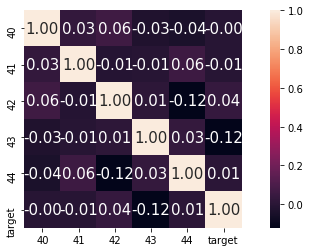

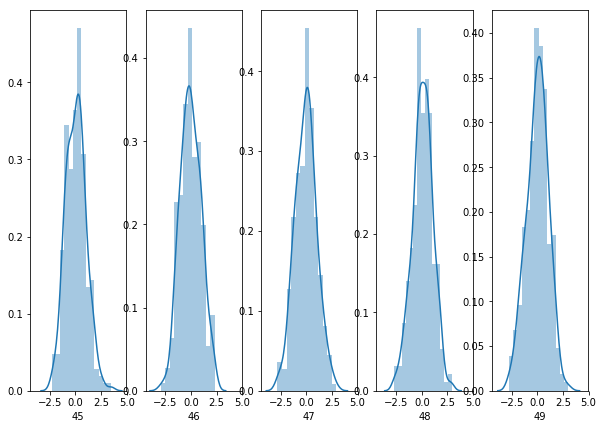

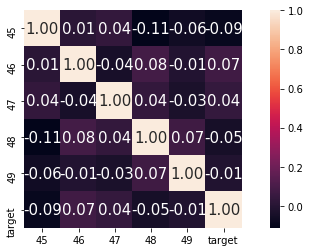

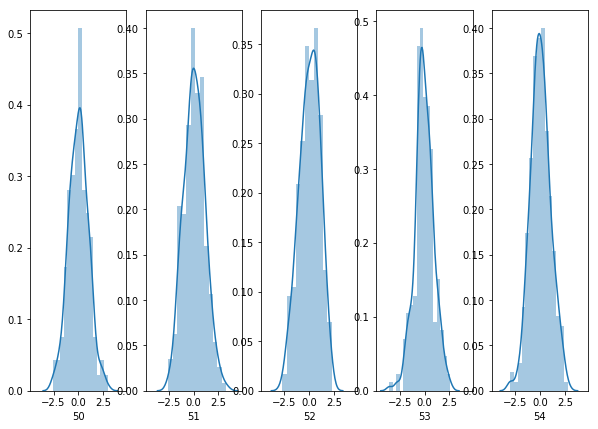

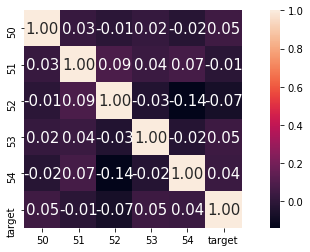

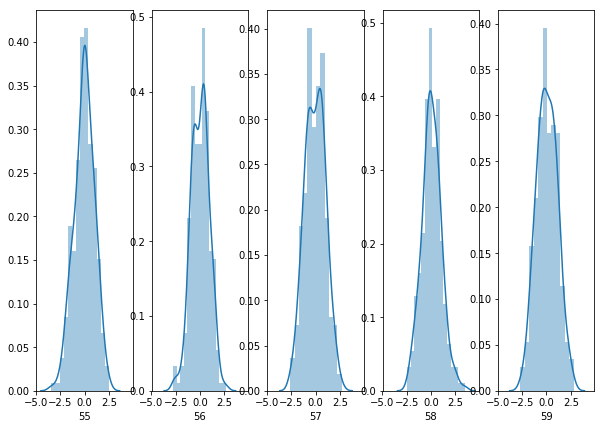

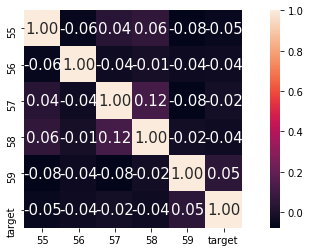

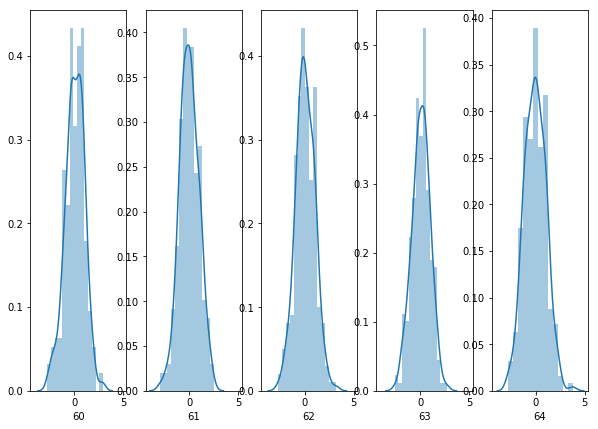

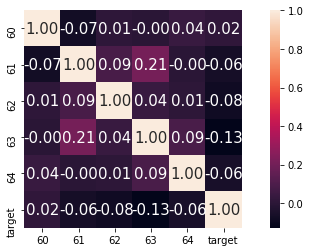

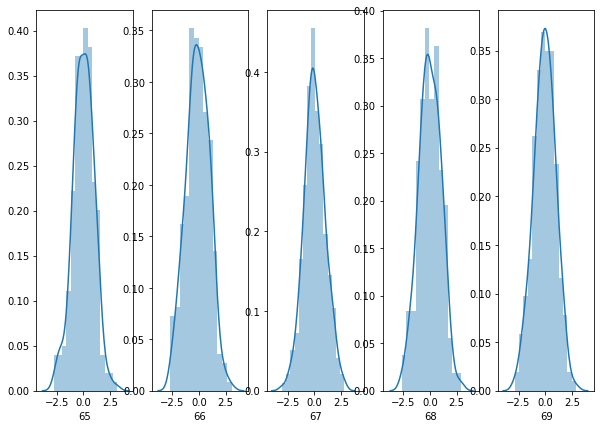

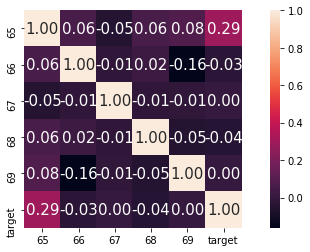

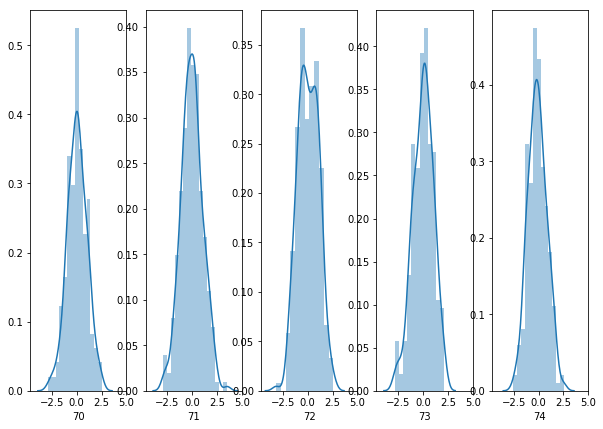

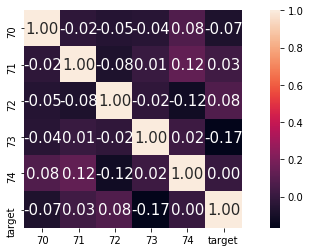

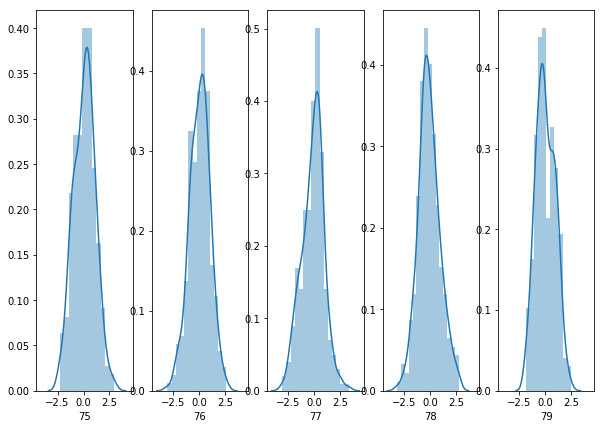

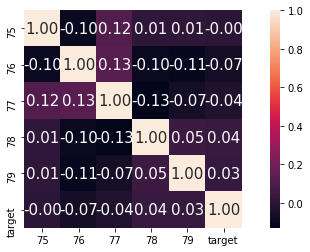

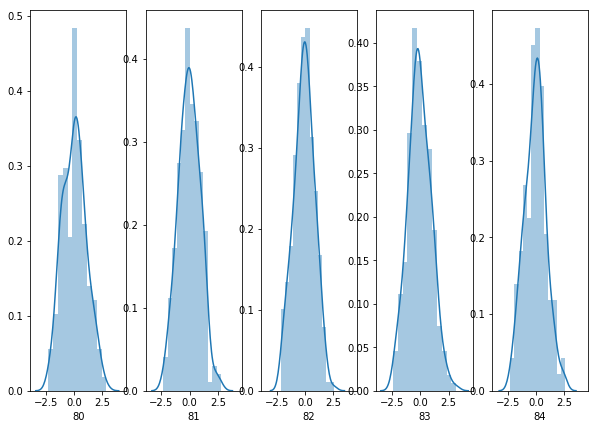

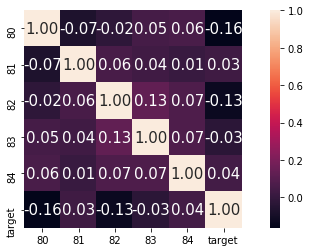

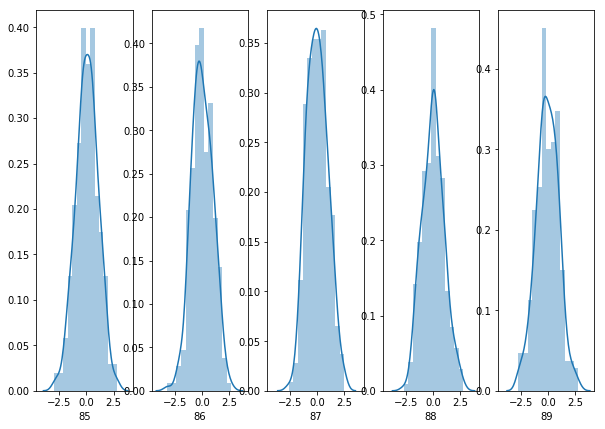

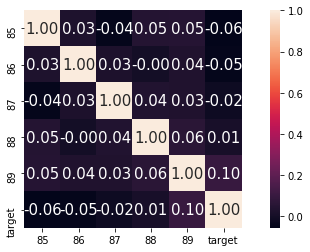

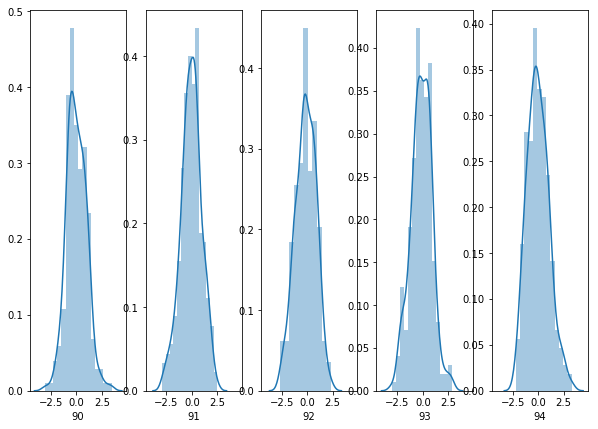

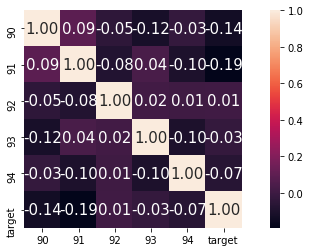

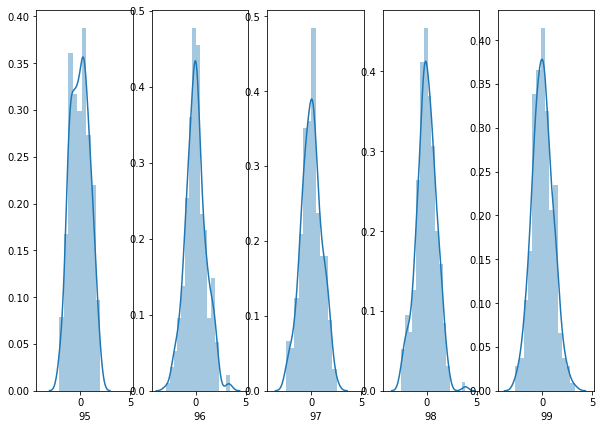

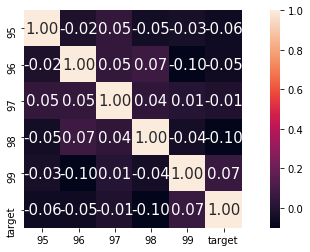

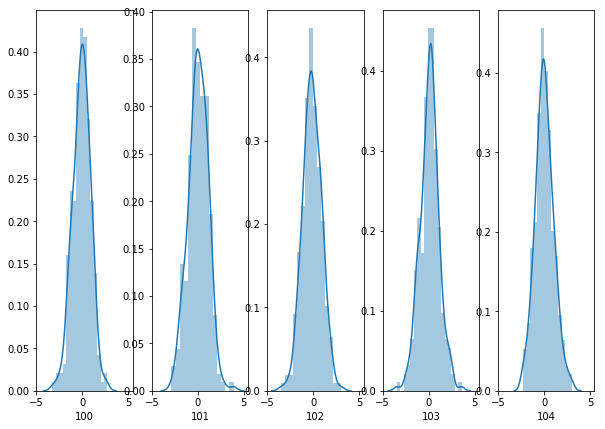

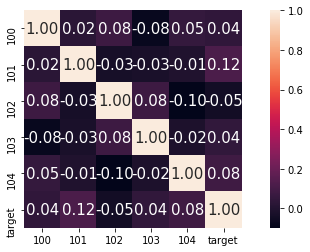

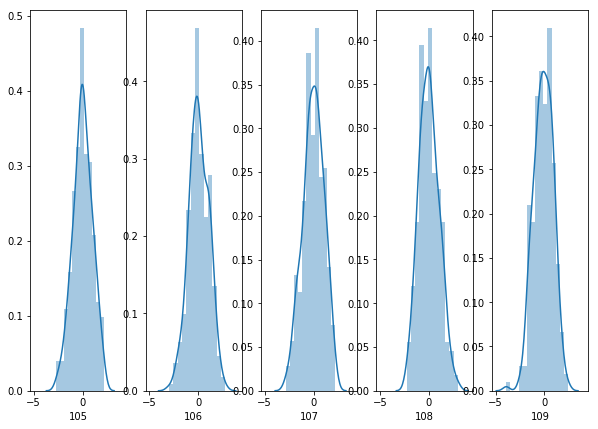

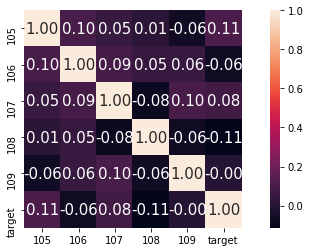

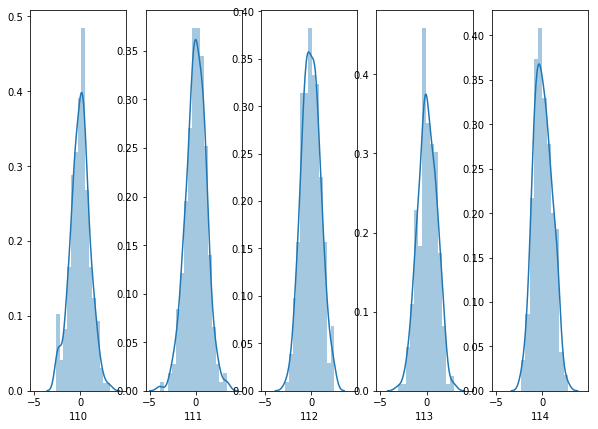

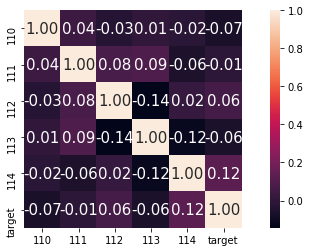

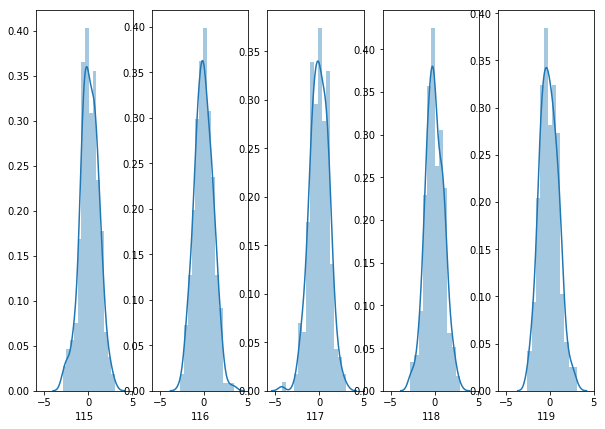

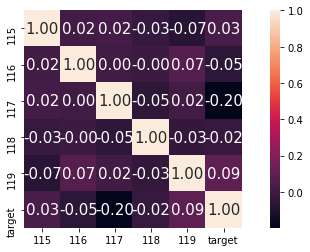

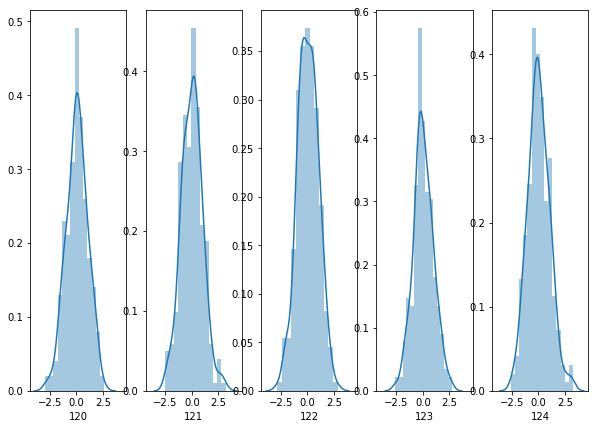

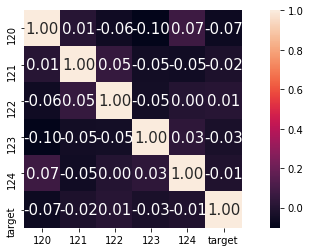

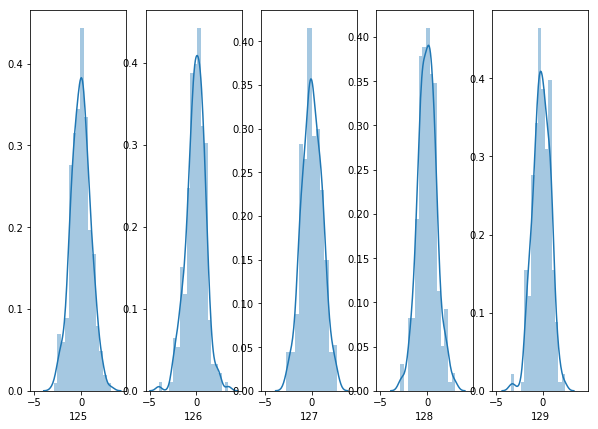

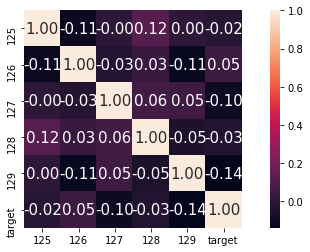

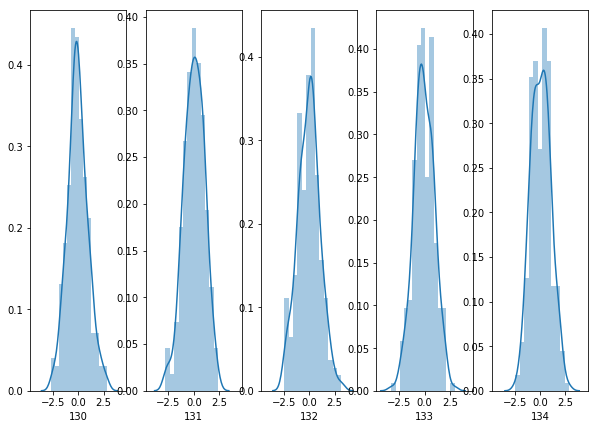

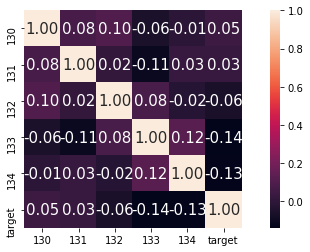

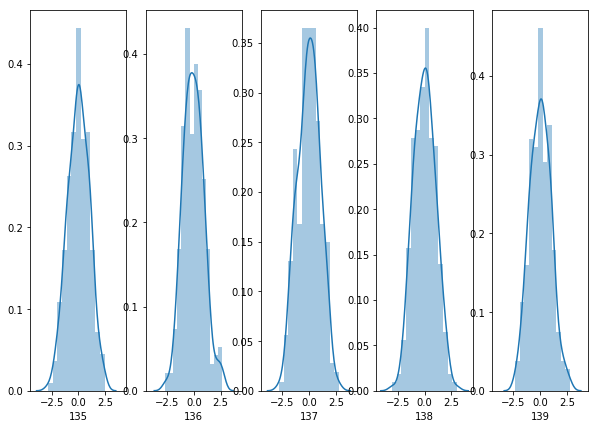

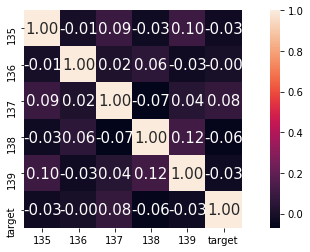

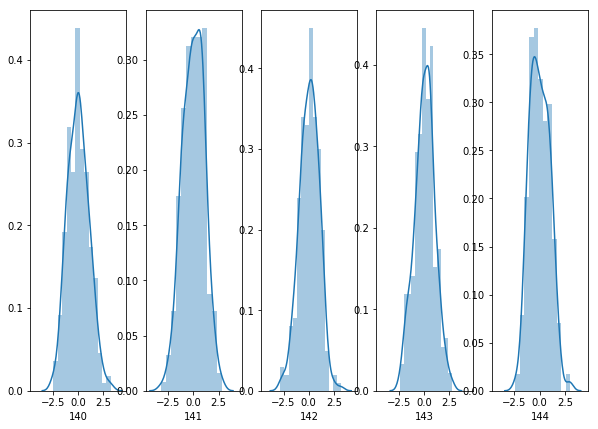

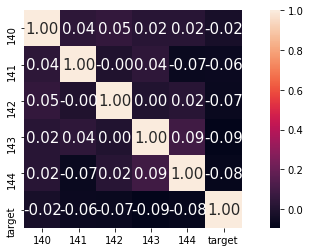

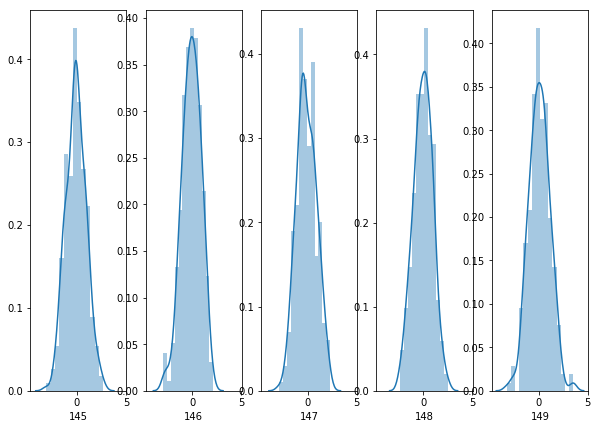

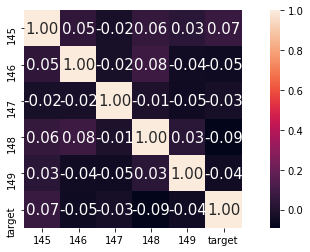

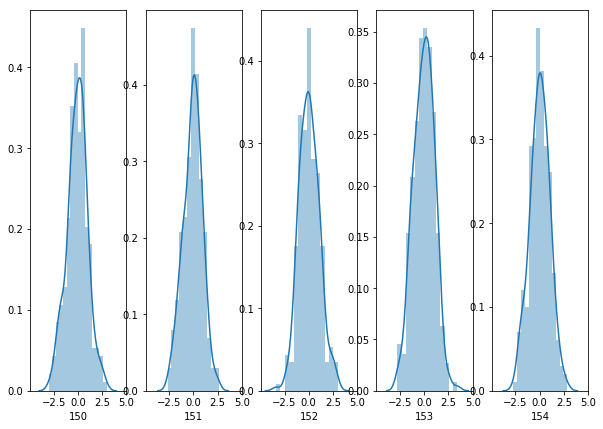

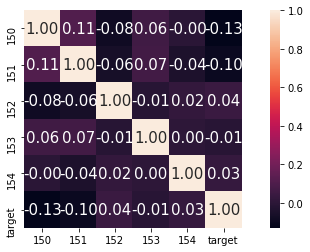

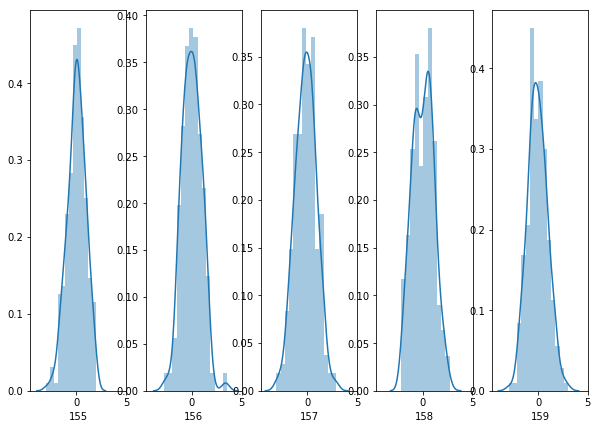

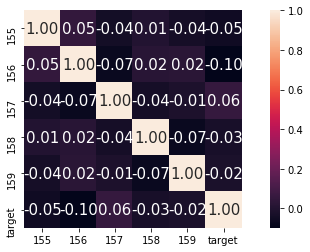

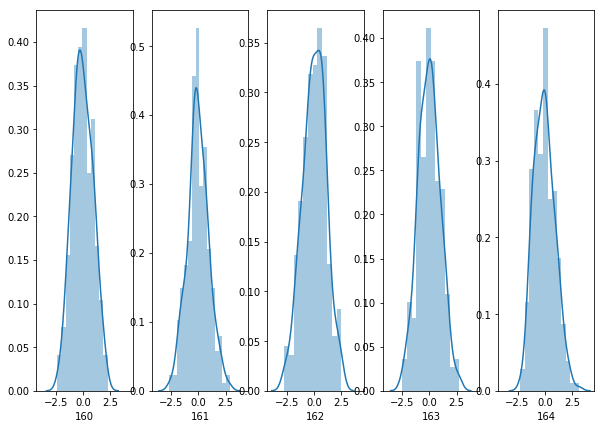

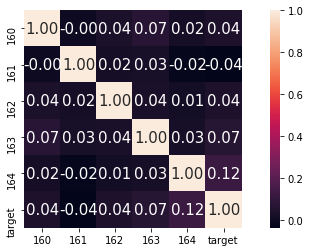

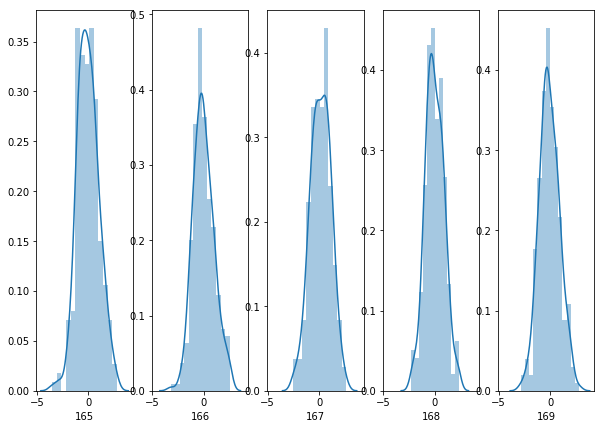

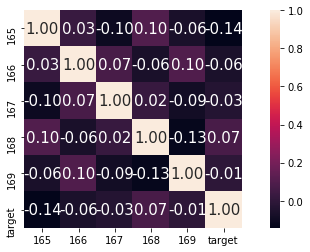

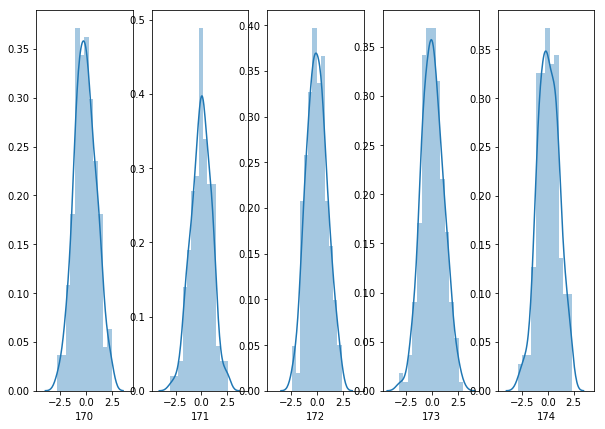

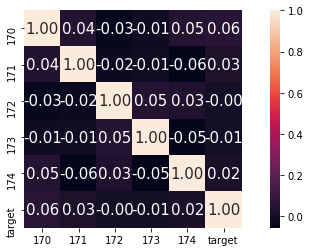

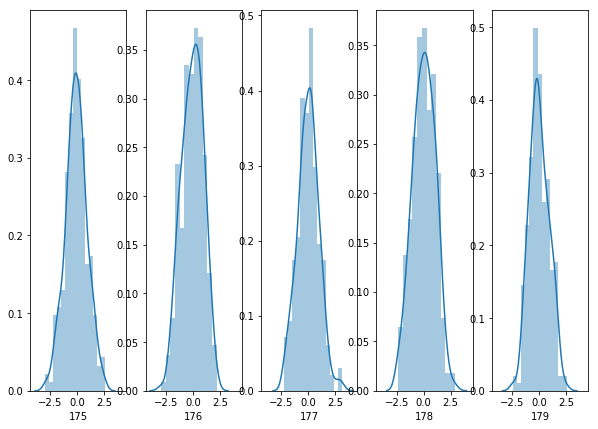

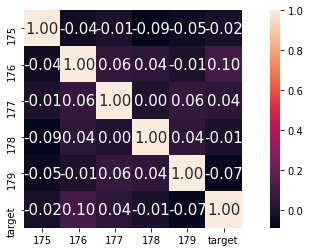

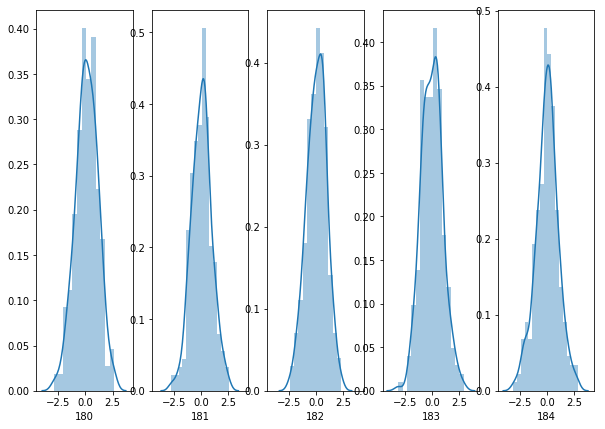

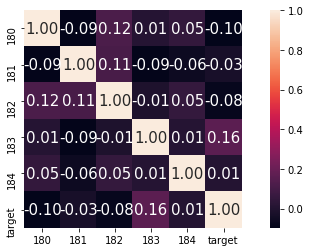

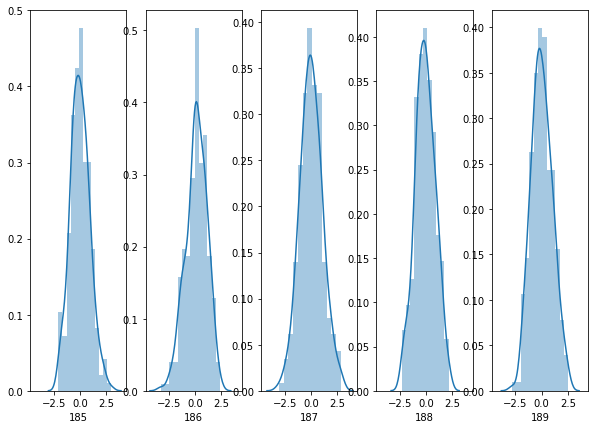

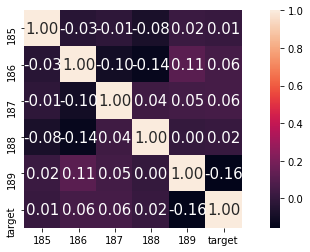

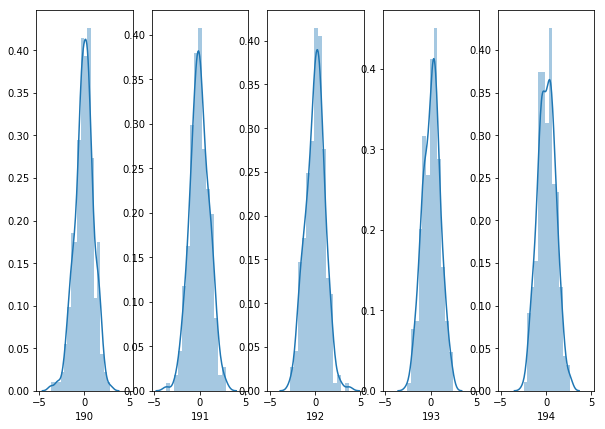

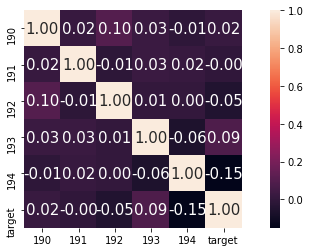

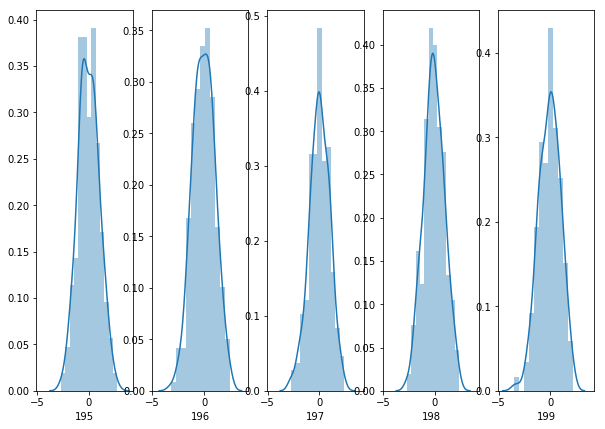

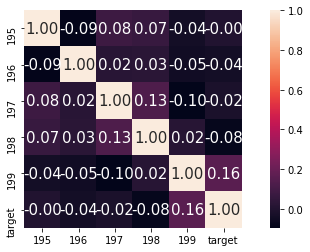

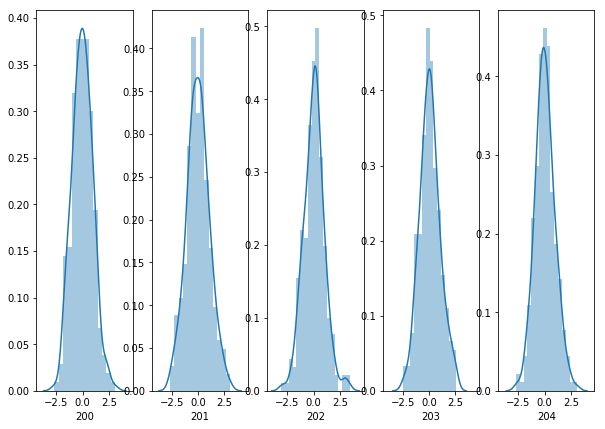

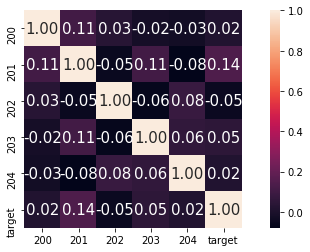

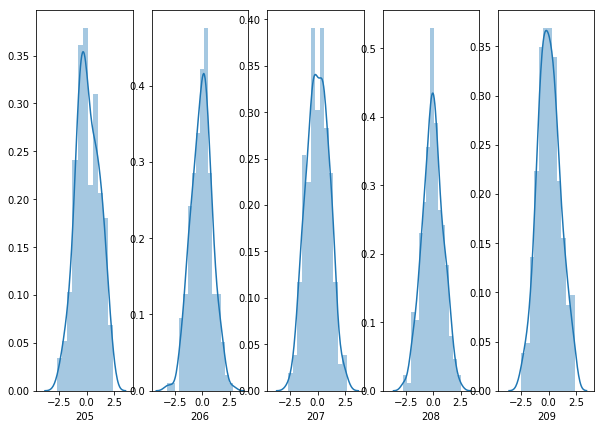

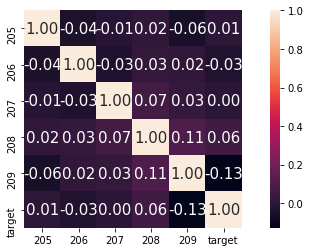

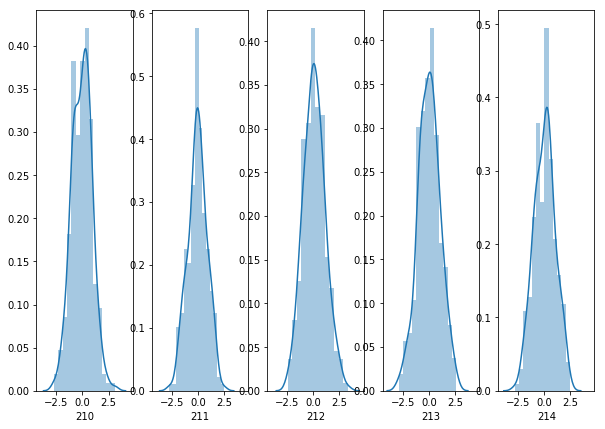

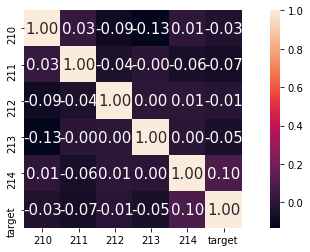

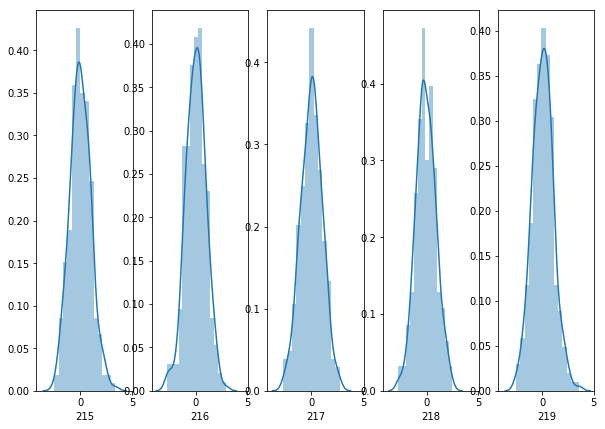

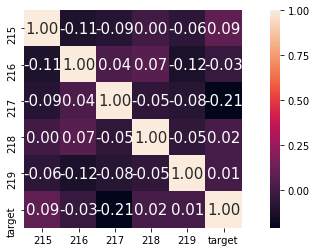

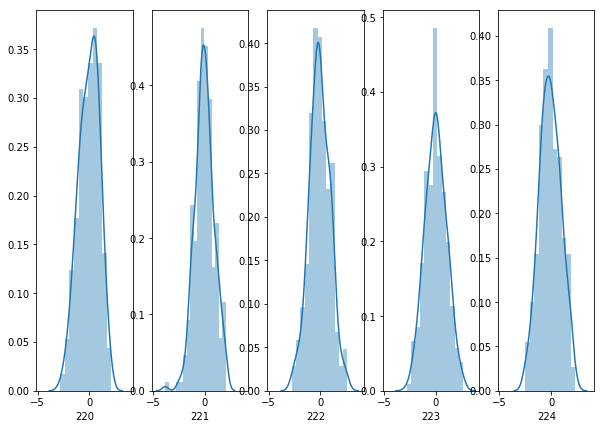

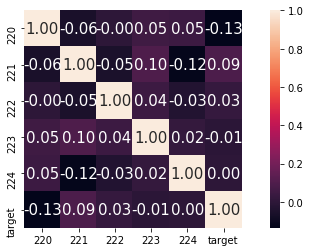

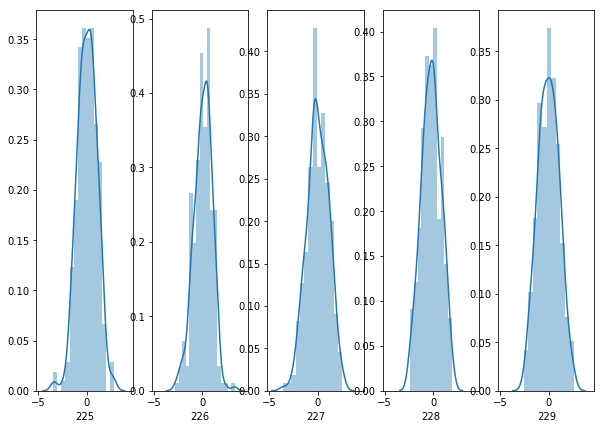

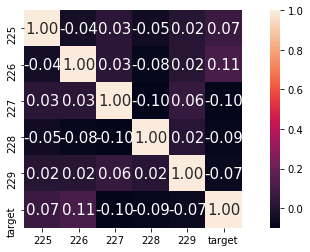

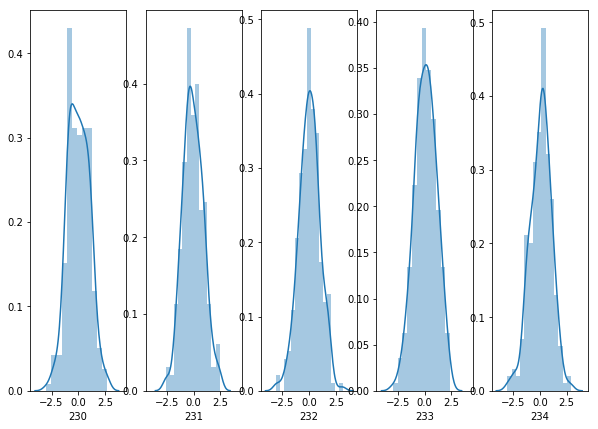

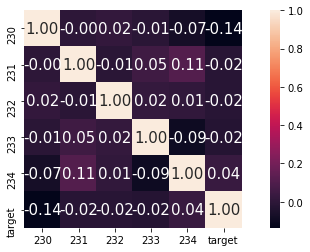

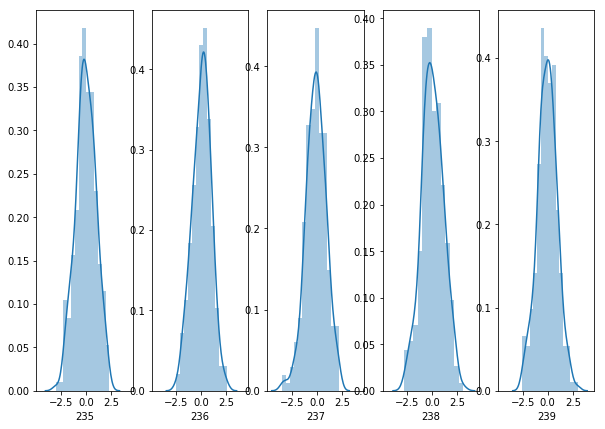

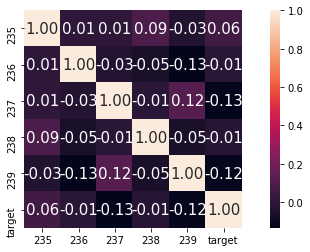

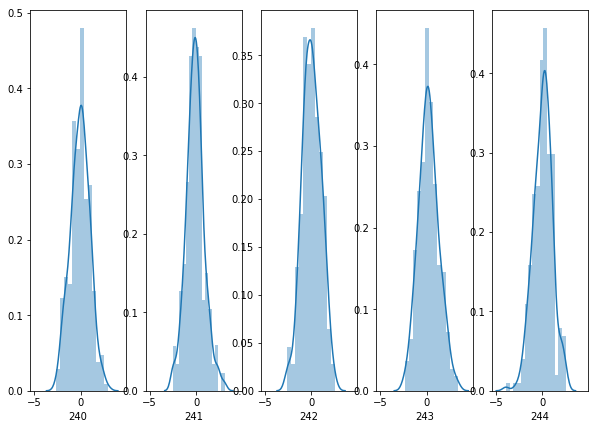

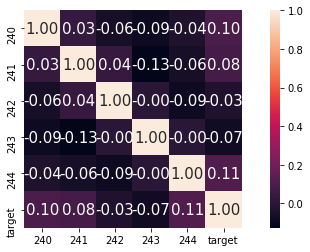

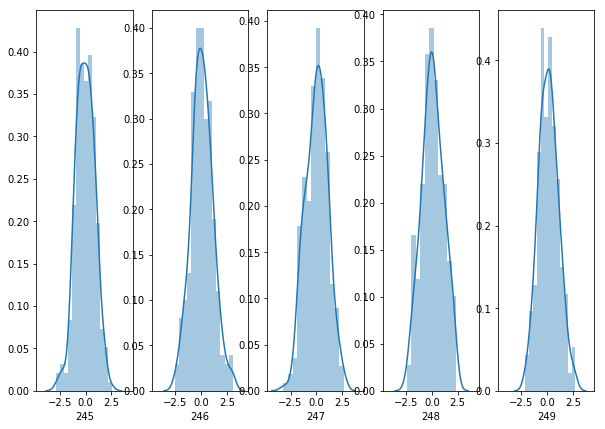

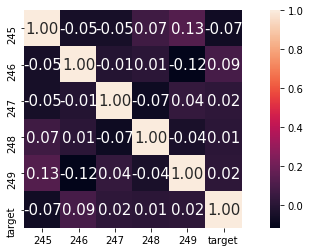

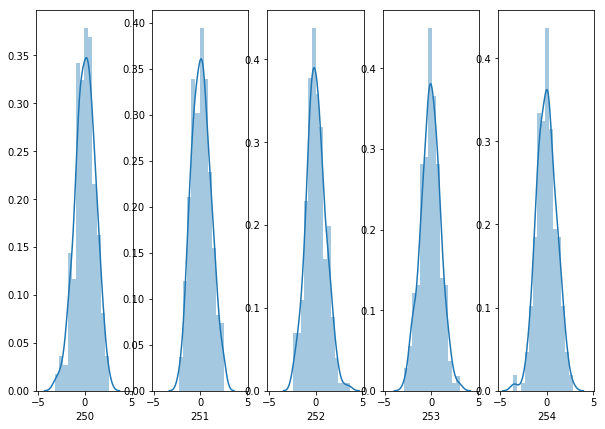

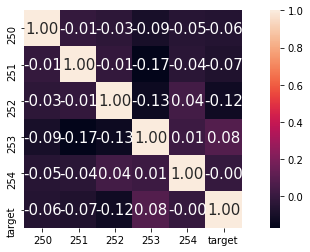

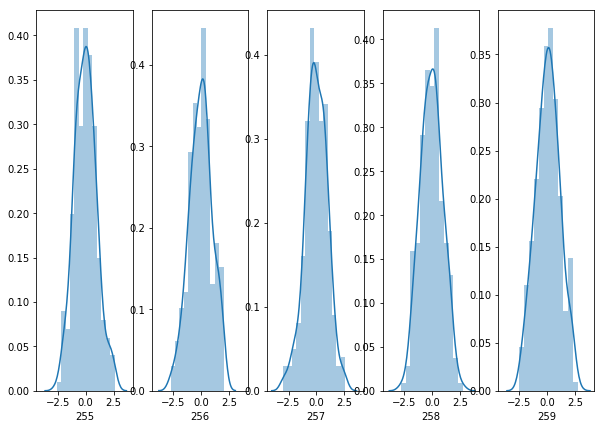

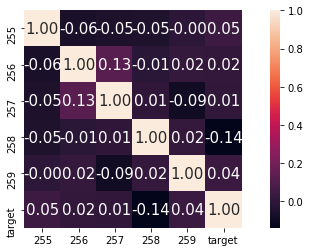

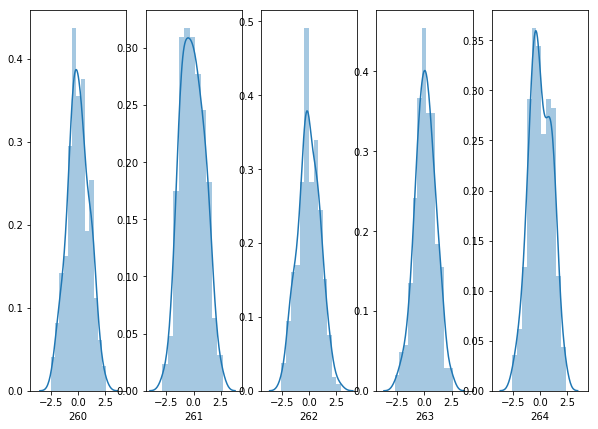

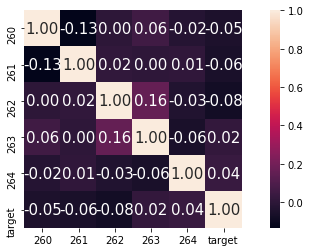

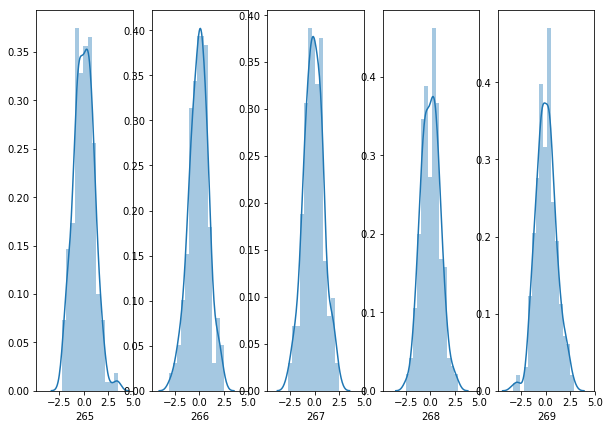

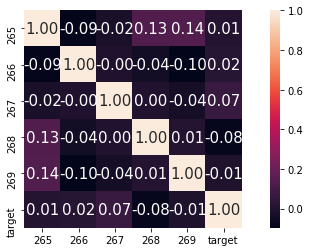

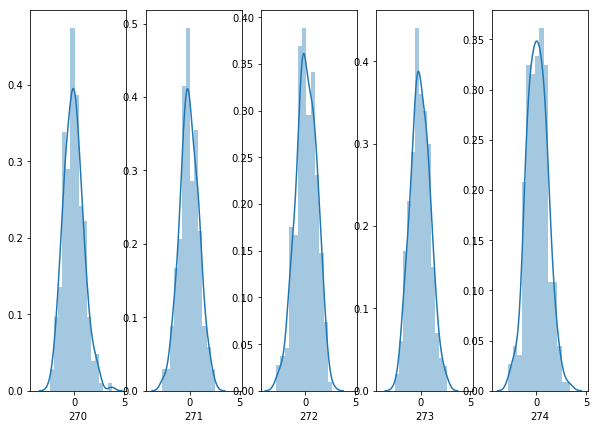

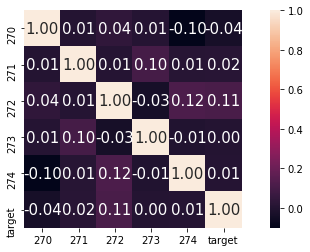

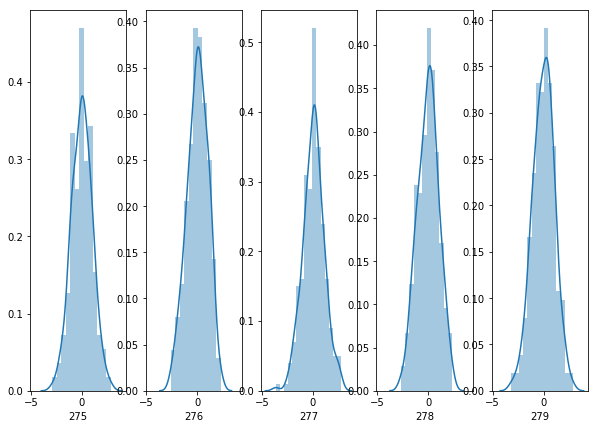

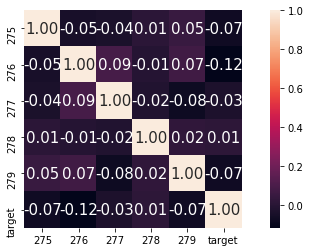

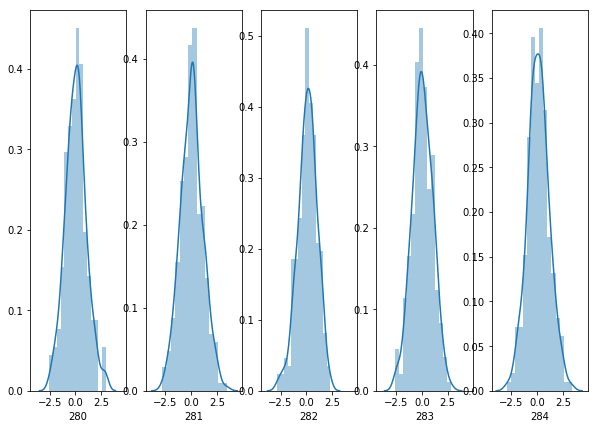

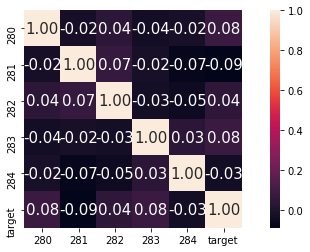

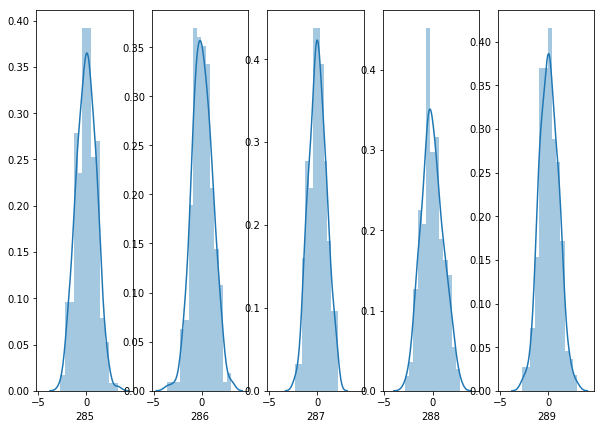

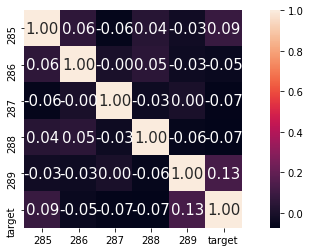

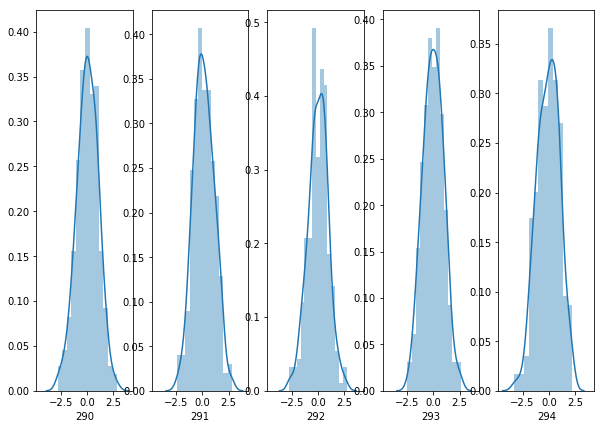

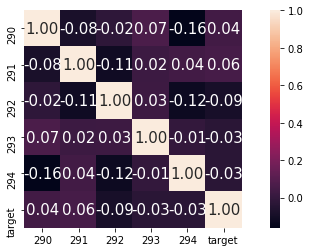

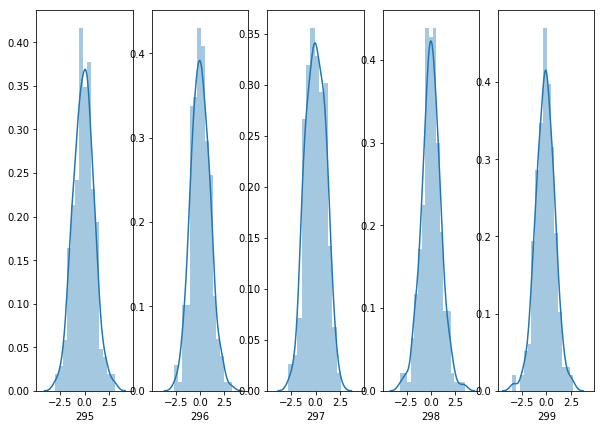

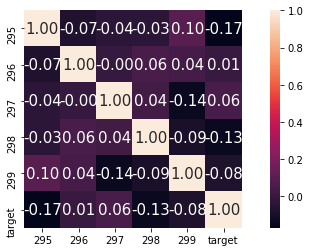

In [12]:
col_chunks = [col_names[i:i+5] for i in range(0,len(col_names),5)]

for item in col_chunks:
    draw_relevant_plots(train_data, item)

In [13]:
from scipy import stats
def calculateCorrelationCoefficientsAndpValues(x_data, y_data, xlabel):
    
    pearson_coef, p_value = stats.pearsonr(x_data, y_data)
    print("The Pearson Correlation Coefficient for %s is %s with a P-value of P = %s" %(xlabel,pearson_coef, p_value))
    
    return (pearson_coef,p_value)

In [14]:
pearson_coeff = []
p_value = []
col_name = []

for col in [i for i in train_data.columns.tolist() if i not in ['id','target']]:
    
    x,y = calculateCorrelationCoefficientsAndpValues(train_data[col], train_data['target'], col)
    pearson_coeff.append(x)
    p_value.append(y)
    col_name.append(col)
    
pearson_table = panda.DataFrame({'column_name':col_name , 'pearson_coeff':pearson_coeff, 'p_value': p_value})
pearson_table.head()

The Pearson Correlation Coefficient for 0 is 0.10896613295780612 with a P-value of P = 0.0855425108978631
The Pearson Correlation Coefficient for 1 is -0.07331927684495224 with a P-value of P = 0.2480801859987947
The Pearson Correlation Coefficient for 2 is -0.015140943820013032 with a P-value of P = 0.8117157095966047
The Pearson Correlation Coefficient for 3 is 0.011549011379043529 with a P-value of P = 0.8558206568804985
The Pearson Correlation Coefficient for 4 is -0.11472596336421398 with a P-value of P = 0.07016102972091894
The Pearson Correlation Coefficient for 5 is -0.05032883942137733 with a P-value of P = 0.42819565779211044
The Pearson Correlation Coefficient for 6 is -0.05706281139477776 with a P-value of P = 0.36894411376906777
The Pearson Correlation Coefficient for 7 is 0.0042391278386217585 with a P-value of P = 0.9468277872565647
The Pearson Correlation Coefficient for 8 is -0.04844250987759829 with a P-value of P = 0.44573026468867594
The Pearson Correlation Coeffici

column_name  pearson_coeff   p_value
0           0       0.108966  0.085543
1           1      -0.073319  0.248080
2           2      -0.015141  0.811716
3           3       0.011549  0.855821
4           4      -0.114726  0.070161

In [15]:
pearson_table[(pearson_table.pearson_coeff>0.1) | (pearson_table.pearson_coeff<-0.1)].sort_values(by=['pearson_coeff'], ascending=False)

column_name  pearson_coeff       p_value
33           33       0.373608  1.060808e-09
65           65       0.293846  2.271695e-06
24           24       0.173096  6.071028e-03
183         183       0.164146  9.321805e-03
199         199       0.159442  1.158492e-02
201         201       0.142238  2.450232e-02
30           30       0.132705  3.599201e-02
289         289       0.127213  4.448368e-02
114         114       0.124792  4.872907e-02
164         164       0.124151  4.990705e-02
101         101       0.118379  6.163324e-02
272         272       0.113909  7.219386e-02
226         226       0.113660  7.282319e-02
17           17       0.110998  7.983294e-02
105         105       0.110589  8.095715e-02
0             0       0.108966  8.554251e-02
244         244       0.108147  8.793511e-02
13           13       0.107828  8.888181e-02
127         127      -0.101558  1.091850e-01
98           98      -0.101702  1.086815e-01
108         108      -0.113875  7.228138e-02
4             4      -0.114726  7.016103e-02
276         276      -0.117467  6.367697e-02
239         239      -0.118166  6.210432e-02
43           43      -0.121413  5.521489e-02
252         252      -0.122335  5.337784e-02
209         209      -0.127391  4.418461e-02
63           63      -0.127440  4.410268e-02
82           82      -0.128248  4.276594e-02
150         150      -0.130454  3.928989e-02
237         237      -0.133168  3.534373e-02
134         134      -0.133731  3.456823e-02
220         220      -0.134738  3.321748e-02
298         298      -0.134760  3.318919e-02
90           90      -0.136230  3.130031e-02
230         230      -0.136263  3.125811e-02
258         258      -0.138332  2.875790e-02
133         133      -0.139100  2.787503e-02
129         129      -0.139439  2.749274e-02
165         165      -0.142526  2.421170e-02
39           39      -0.142915  2.382252e-02
16           16      -0.144267  2.251444e-02
194         194      -0.150384  1.734030e-02
189         189      -0.155956  1.356259e-02
80           80      -0.162558  1.003763e-02
73           73      -0.167557  7.934978e-03
295         295      -0.170501  6.888922e-03
91           91      -0.192536  2.230678e-03
117         117      -0.197496  1.701034e-03
217         217      -0.207215  9.814931e-04

In [16]:
reqd_columns = pearson_table[(pearson_table.pearson_coeff>0.1) | (pearson_table.pearson_coeff<-0.1)].sort_values(by=['pearson_coeff'], ascending=False).column_name.values.tolist()
reqd_columns[:5], len(reqd_columns)

(['33', '65', '24', '183', '199'], 50)

In [17]:
f,p = f_classif(train_data[[i for i in train_data.columns.tolist() if i not in ['id','target']]], train_data.target)
f.shape, p.shape, len([i for i in train_data.columns.tolist() if i not in ['id','target']])

anova_table = panda.DataFrame({
    
        'col_name': [i for i in train_data.columns.tolist() if i not in ['id','target']],
        'f_value': f,
        'p_value': p
})

anova_columns = anova_table.sort_values(by=['p_value'], ascending = True).head(40).col_name.values.tolist()


In [18]:
reqd_columns1 = list(set(reqd_columns).intersection(set(anova_columns)))
reqd_columns1

['39',
 '16',
 '217',
 '73',
 '63',
 '82',
 '189',
 '133',
 '4',
 '258',
 '252',
 '165',
 '24',
 '237',
 '183',
 '289',
 '209',
 '164',
 '276',
 '90',
 '199',
 '230',
 '65',
 '117',
 '101',
 '295',
 '129',
 '298',
 '194',
 '201',
 '80',
 '30',
 '134',
 '114',
 '220',
 '150',
 '91',
 '239',
 '43',
 '33']

In [19]:
f = mutual_info_classif(train_data[[i for i in train_data.columns.tolist() if i not in ['id','target']]], train_data.target)
f.shape,  len([i for i in train_data.columns.tolist() if i not in ['id','target']])

mutual_info_table = panda.DataFrame({
    
        'col_name': [i for i in train_data.columns.tolist() if i not in ['id','target']],
        'f_value': f,

})

# anova_columns =
mutual_info_table.sort_values(by=['f_value'], ascending = False).head(25)

col_name   f_value
165      165  0.090288
17        17  0.084530
2          2  0.074098
189      189  0.072609
33        33  0.068827
91        91  0.067793
219      219  0.065381
98        98  0.063624
298      298  0.062085
193      193  0.061902
231      231  0.061553
36        36  0.059514
130      130  0.059391
146      146  0.057691
92        92  0.056009
289      289  0.055929
122      122  0.055675
65        65  0.055640
247      247  0.054742
96        96  0.054679
18        18  0.053523
194      194  0.052523
167      167  0.050322
13        13  0.049684
80        80  0.048294

There are a couple of observations that we can make out of the above diagrams:

1. ALmost all independent variables are distributed within -2.5 and 2.5
2. Almost all have near normal distributions
3. Almost none have any significant outliers
4. Pearsons correlation coeff for each indedepent variable with target variable is pretty low
5. There are no categorical data
6. pearsons correlation coefficient scores are pretty less and we will take all whose scores are above 0.1 and below -0.1

#### Based on above data analysis, we are going to attempt 3 things

1. create a baseline model out of gridsearch for the data using the usual suspects of classifiers. 


2. Plot learning curve and auc/roc scores for each


3. try dimensionality reduction techniques such as PCA,LDA and t-SNE and run on baseline models created in step 1.


4. try SMOTE and run on the same model created in point 1 and compare scores



### STEP 1: Run handful of usual suspect classifiers using selected 50 features giving highest coeff scores

<br><br>

In [20]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

In [21]:

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  model_name, k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes for model:"+model_name)
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
def plot_roc_auc_curve(false_positive_rate, true_positive_rate, model_name):
        
    plot.figure(figsize=(10,3))
    plot.plot(list(false_positive_rate), list(true_positive_rate),  label = "ROC Curve for model: "+model_name)     
    plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
    plot.plot([0, 0, 1], [0,1, 1], ':', label = 'Perfect Score')
    auc_score = auc(false_positive_rate, true_positive_rate)
    plot.title('ROC Curve for model: %s with AUC %.2f'%(model_name, auc_score))
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.legend(loc='best')
    plot.show()
    
    
def plot_precision_recall_curve(precision, recall, model_name):
    
    plot.figure(figsize=(10,3))
    plot.plot(list(recall), list(precision),  label = "Precision/Recall Curve for model: "+model_name)     
#     plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing') #
    plot.title('Precision Recall Curve for model: %s'%model_name)
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.legend(loc='best')
    plot.show()


    


In [22]:
def runGridSearchAndPredict(pipeline,model_name, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
#     pass

    response =  {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)

    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(x_train, y_train, search.best_estimator_, model_name)
#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(range(_y_test.shape[1])))
        _matrix = confusion_matrix(y_true = y_test ,y_pred = y_prediction, labels = list(set(y_test)))
        classes = list(set(y_test))
        plot_confusion_matrix(_matrix, classes, title = "Confusion matrix for model:"+model_name)
        
    with predict_proba_timer:

        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            print('inside decision function')
            y_probability = gridsearch.predict_proba(x_test)
            number_of_classes = len(np.unique(y_train))
            false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:, 1])
            response['roc_auc_score'] = roc_auc_score(y_test, y_probability[:,1])
            response['roc_curve'] = (false_positive_rate, true_positive_rate)  
            response['roc_curve_false_positive_rate'] = false_positive_rate
            response['roc_curve_true_positive_rate'] = true_positive_rate
            precision, recall, _ = precision_recall_curve(y_test, y_probability[:,1])
            plot_roc_auc_curve(false_positive_rate, true_positive_rate, model_name)
            plot_precision_recall_curve(precision, recall, model_name)
            
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_score'] = 0
            response['roc_curve'] = 0
            response['roc_curve_false_positive_rate'] = 0
            response['roc_curve_true_positive_rate'] = 0
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['f1_score_micro']  = f1_score(y_test, y_prediction, average ='micro')
    response['f1_score_macro']  = f1_score(y_test, y_prediction, average ='macro')
    response['best_estimator'] = search.best_estimator_
    response['confusion_matrix'] = _matrix
    
    return response


def plotROCCurveAcrossModels(positive_rates_sequence, model_name):
    
    plot.figure(figsize=(10,5))
    for plot_values, label_name in zip(positive_rates_sequence, model_name):
        
        plot.plot(list(plot_values[0]), list(plot_values[1]),  label = "ROC Curve for model: "+label_name)
        
    plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing') #
    plot.title('ROC Curve across models')
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.legend(loc='best')
    plot.show()

In [23]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline_steps = [('scaler', scaler),(model_name, model)] if scaler is not None else [(model_name, model)]
            pipeline = Pipeline(pipeline_steps)

            result = runGridSearchAndPredict(pipeline, 
                                             model_name,
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = score)

            _y_prediction = result['_y_prediction']

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_score'] = result.get('roc_auc_score')
            model_metrics[model_name]['roc_curve_true_positive_rate'] = result.get('roc_curve_true_positive_rate')
            model_metrics[model_name]['roc_curve_false_positive_rate'] = result.get('roc_curve_false_positive_rate')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')


    print(timer.took)
    
    return model_metrics


In [24]:

classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    LogisticRegression(random_state = 1, solver='liblinear'),
    LogisticRegression(random_state = 1, solver='newton-cg'),
    LogisticRegression(random_state = 1, solver='sag'),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
#     KNeighborsClassifier(metric = 'minkowski'),
#     RidgeClassifier(random_state = 123), 
#     SVC(kernel="linear"),
#     SVC(),
#     ExtraTreeClassifier(random_state = 123),
#     GaussianProcessClassifier(random_state = 123),
#     BernoulliNB(),
#     BaggingClassifier(base_estimator = LogisticRegression(random_state = 1)),
#     BaggingClassifier(base_estimator = BernoulliNB()),
#     GradientBoostingClassifier(random_state= 123),
#     LGBMClassifier(objective = 'binary'),
#     XGBClassifier(objective = 'binary:logistic')
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'logisticregression_liblinear_l2',
            'logisticregression_newton_cg',
            'logisticregression_sag',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'linear_svc',
            'gamma_svc',
            'extra_trees',
            'gaussian_process',
            'bernoulli',
            'bagging_logistic',
            'bagging_bernoulli',
            'gradient_boosting_classifier',
            'lgbm_classifier',
            'xgb'
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {
             'logisticregression__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression__penalty':['l1','l2'],
             'logisticregression__solver':['saga','liblinear']
            },
            {
             'logisticregression_liblinear_l2__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_liblinear_l2__penalty':['l2'],
             'logisticregression_liblinear_l2__dual':[True]
            },
            {
             'logisticregression_newton_cg__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_newton_cg__penalty':['l2'],
            },
            {
             'logisticregression_sag__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_sag__penalty':['l2'],
            },
    
            {'decisiontreeclassifier__max_depth':[6,8,10],
             'decisiontreeclassifier__criterion':['gini','entropy'],
             'decisiontreeclassifier__max_features':['auto','sqrt','log2'],
            },
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini','entropy']} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]},
            {'linear_svc__C':[0.025]},
            {'gamma_svc__gamma':[2,4],'gamma_svc__C':[1,5]},
            {'extra_trees__max_depth':[6,8,12],'extra_trees__criterion': ['gini','entropy']} ,
            {'gaussian_process__max_iter_predict':[200,400]} ,
            {'bernoulli__alpha':[0.2,0.6,1.2]} ,
            {'bagging_logistic__base_estimator__C':[1.2,0.02,2.2,4], 
             'bagging_logistic__base_estimator__penalty':['l1','l2'],
             'bagging_logistic__n_estimators': [5,8,10]
            },
            {'bagging_bernoulli__base_estimator__alpha':[1.2,0.02,2.2,4], 
             'bagging_bernoulli__n_estimators': [5,8,10]
            },
            {
                'gradient_boosting_classifier__loss':['deviance','exponential'],
                'gradient_boosting_classifier__learning_rate':[0.5,1.2],
                'gradient_boosting_classifier__n_estimators':[100,500,1000],
                'gradient_boosting_classifier__criterion':['friedman_mse','mse','mae'],
                'gradient_boosting_classifier__max_depth':[6,8,16,20],
            },
            {
                 'lgbm_classifier__num_leaves':[25,], \
#                  'lgbm_classifier__min_data_in_leaf':[20],\
                 'lgbm_classifier__max_depth':[20,], \
                 'lgbm_classifier__learning_rate' : [0.01,],\
                 'lgbm_classifier__min_child_samples' :[2,], \
                 'lgbm_classifier__n_estimators' : [5000,], \
                 'lgbm_classifier__num_boost_round' : [100], \
                 'lgbm_classifier__feature_fraction' : [0.9,], \
                 'lgbm_classifier__bagging_freq' : [1,], \
                 'lgbm_classifier__bagging_seed' : [123], \
            },
             {
                'xgb__max_depth':[6,8,10],
                 'xgb__learning_rate':[0.1,0.5,1,2],
                 'xgb__n_estimators':[100,400,1000],             
                 'xgb__booster':['gbtree','dart'],
                 'xgb__subsample':[0.5, 0.2,0.8]
            },
    
]


In [25]:
x = train_data[[i for i in train_data.columns.tolist() if i not in ['target','id']]]
y = train_data['target']

lda = LinearDiscriminantAnalysis(n_components=10, solver='eigen',shrinkage='auto')
x_lda = lda.fit_transform(x,y)
# explained_variance = lda.explained_variance_ratio_
# explained_variance.shape, x_lda.shape

x_train,x_test,y_train,y_test = train_test_split(x_lda,y , stratify = y, test_size = 0.3, random_state = 123)

In [26]:
x = train_data[[i for i in train_data.columns.tolist() if i not in ['target','id']]]

x = MinMaxScaler(feature_range=(0,1)).fit_transform(x)
x = SelectKBest(chi2, k = 50).fit_transform(x,train_data.target)
# x = train_data_k
# x = train_data[anova_columns]
y = train_data['target']

# x_train,x_test,y_train,y_test = train_test_split(x,y , stratify = y, test_size = 0.3, random_state = 123)

In [27]:
x_train.shape

(175, 1)

In [28]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'roc_auc'

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 30}
Grid Search Best score  0.7284917980570155
Code block 'training' took(HH:MM:SS): 0:00:00.053343
Code block 'testing' took(HH:MM:SS): 0:00:00.000253
F1 score 0.7552
Classification report  
               precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.79      0.85      0.82        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.74      0.72      0.73        75
weighted avg       0.76      0.76      0.76        75



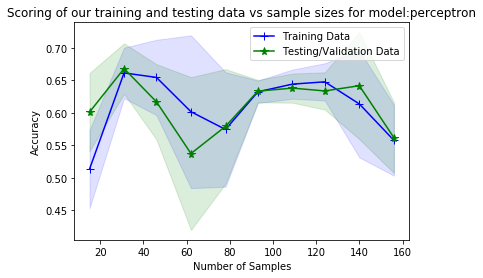

Confusion matrix, without normalization
[[16 11]
 [ 7 41]]


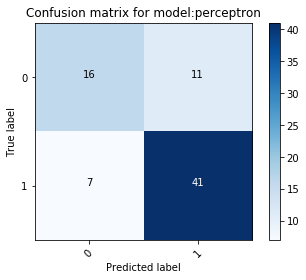

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.387058
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000014
Grid Search Best parameters  {'logisticregression__C': 1.2, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Grid Search Best score  0.7284917980570155
Code block 'training' took(HH:MM:SS): 0:00:00.351105
Code block 'testing' took(HH:MM:SS): 0:00:00.000103
F1 score 0.7552
Classification report  
               precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.79      0.85      0.82        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.74      0.72      0.73        75
weighted avg       0.76      0.76      0.76        75



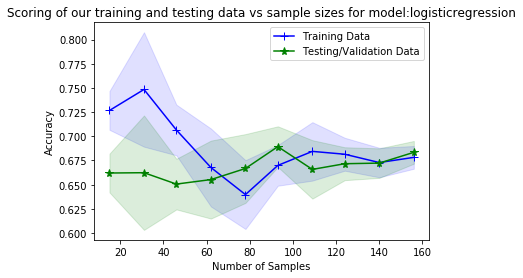

Confusion matrix, without normalization
[[16 11]
 [ 7 41]]


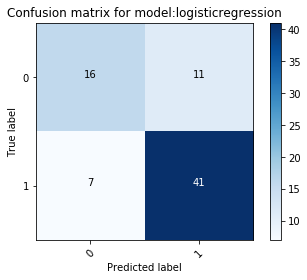

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.398083
inside decision function


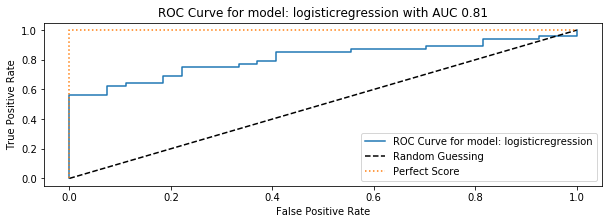

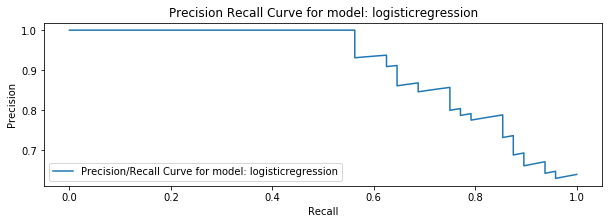

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.266244
Grid Search Best parameters  {'logisticregression_liblinear_l2__C': 1.2, 'logisticregression_liblinear_l2__dual': True, 'logisticregression_liblinear_l2__penalty': 'l2'}
Grid Search Best score  0.7284917980570155
Code block 'training' took(HH:MM:SS): 0:00:00.090810
Code block 'testing' took(HH:MM:SS): 0:00:00.000196
F1 score 0.7552
Classification report  
               precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.79      0.85      0.82        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.74      0.72      0.73        75
weighted avg       0.76      0.76      0.76        75



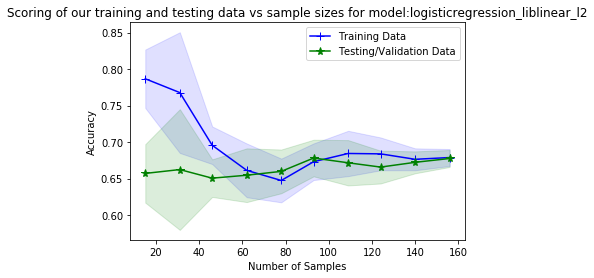

Confusion matrix, without normalization
[[16 11]
 [ 7 41]]


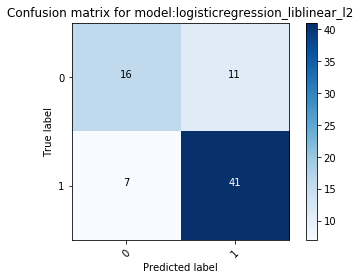

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.365256
inside decision function


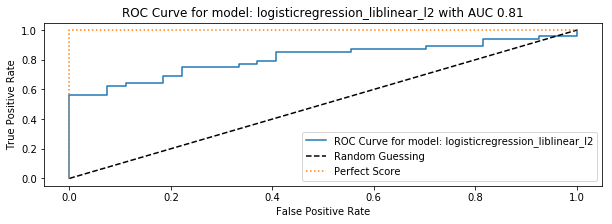

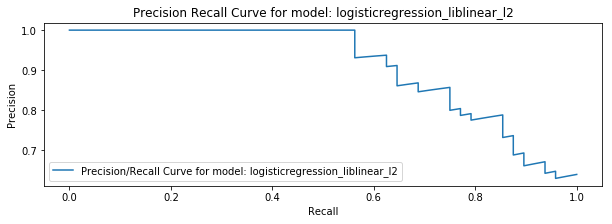

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.214802
Grid Search Best parameters  {'logisticregression_newton_cg__C': 1.2, 'logisticregression_newton_cg__penalty': 'l2'}
Grid Search Best score  0.7284917980570155
Code block 'training' took(HH:MM:SS): 0:00:00.138256
Code block 'testing' took(HH:MM:SS): 0:00:00.000101
F1 score 0.7552
Classification report  
               precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.79      0.85      0.82        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.74      0.72      0.73        75
weighted avg       0.76      0.76      0.76        75



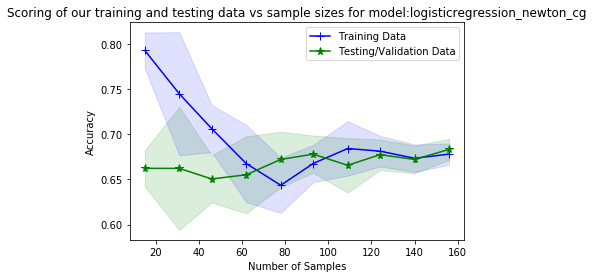

Confusion matrix, without normalization
[[16 11]
 [ 7 41]]


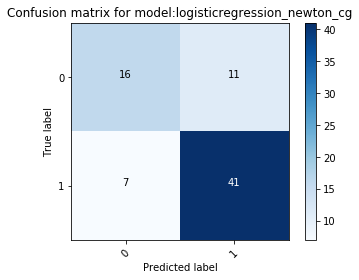

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.509759
inside decision function


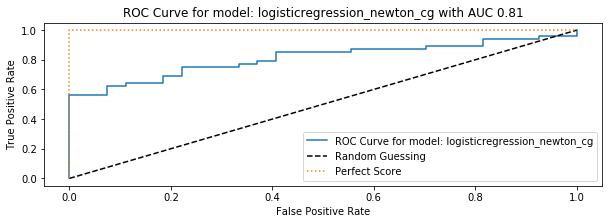

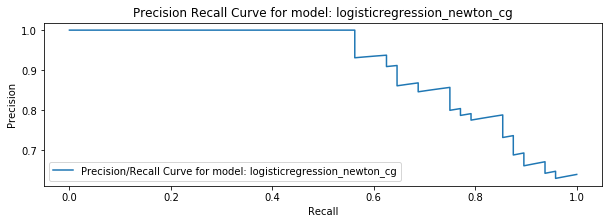

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.215377
Grid Search Best parameters  {'logisticregression_sag__C': 1.2, 'logisticregression_sag__penalty': 'l2'}
Grid Search Best score  0.7284917980570155
Code block 'training' took(HH:MM:SS): 0:00:00.105438
Code block 'testing' took(HH:MM:SS): 0:00:00.000115
F1 score 0.7552
Classification report  
               precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.79      0.85      0.82        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.74      0.72      0.73        75
weighted avg       0.76      0.76      0.76        75



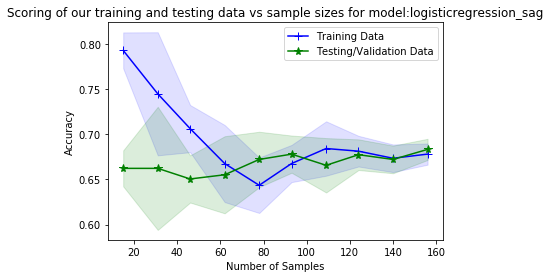

Confusion matrix, without normalization
[[16 11]
 [ 7 41]]


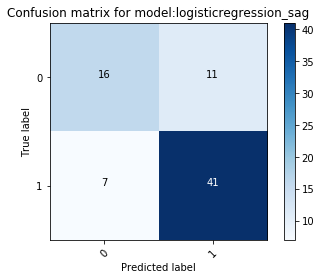

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.401797
inside decision function


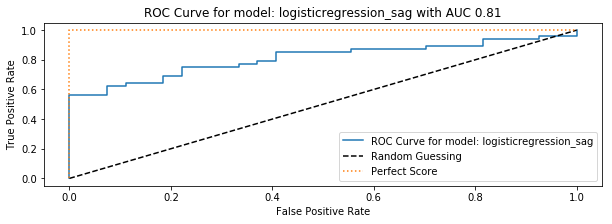

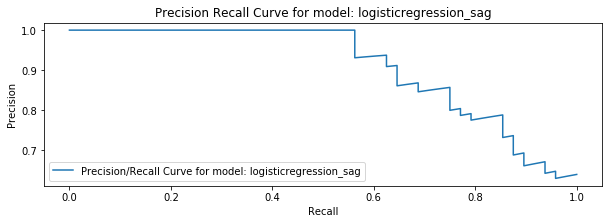

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.264586
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__max_features': 'auto'}
Grid Search Best score  0.6503896827809872
Code block 'training' took(HH:MM:SS): 0:00:00.243904
Code block 'testing' took(HH:MM:SS): 0:00:00.000280
F1 score 0.7066666666666667
Classification report  
               precision    recall  f1-score   support

           0       0.59      0.59      0.59        27
           1       0.77      0.77      0.77        48

   micro avg       0.71      0.71      0.71        75
   macro avg       0.68      0.68      0.68        75
weighted avg       0.71      0.71      0.71        75



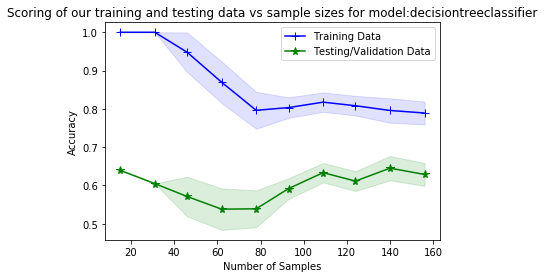

Confusion matrix, without normalization
[[16 11]
 [11 37]]


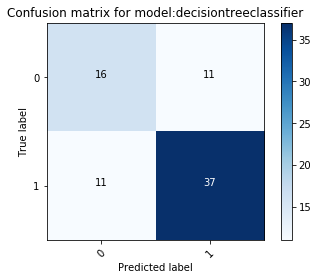

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.338970
inside decision function


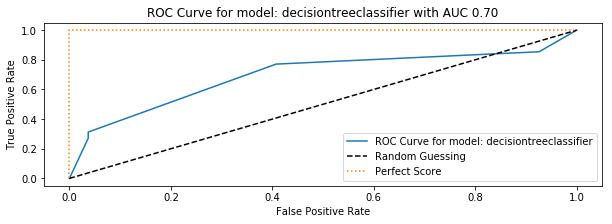

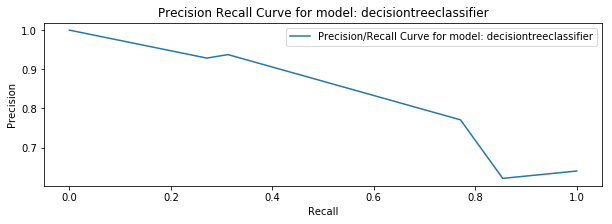

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.211358
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6032940972071407
Code block 'training' took(HH:MM:SS): 0:00:00.303534
Code block 'testing' took(HH:MM:SS): 0:00:00.001793
F1 score 0.7087841945288754
Classification report  
               precision    recall  f1-score   support

           0       0.59      0.63      0.61        27
           1       0.78      0.75      0.77        48

   micro avg       0.71      0.71      0.71        75
   macro avg       0.68      0.69      0.69        75
weighted avg       0.71      0.71      0.71        75



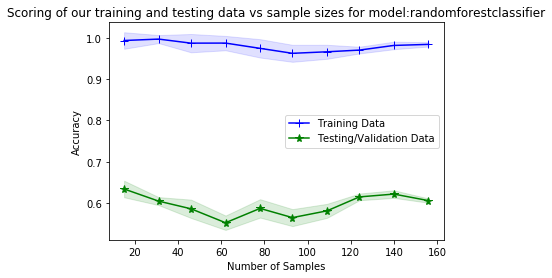

Confusion matrix, without normalization
[[17 10]
 [12 36]]


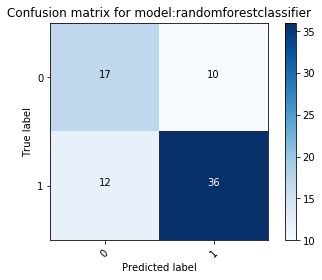

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.211216
inside decision function


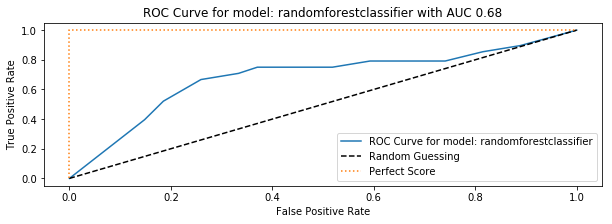

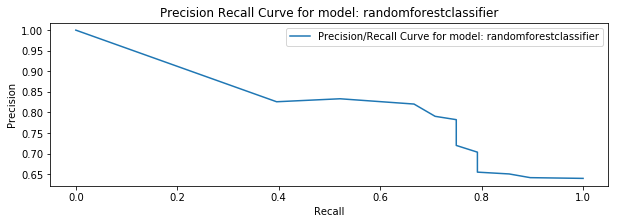

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.221346
Code block 'overalltime' took(HH:MM:SS): 0:00:06.328619
6328.618768186641


In [29]:
response1 = execute(
        x_train,
        y_train,
        x_test,
        y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=None)

In [34]:
results = panda.DataFrame(response1).transpose()
results.head()
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_score',
         'testing_time',
         'training_time',
        ]]\
.sort_values(by=['roc_auc_score',],ascending=False)

f1_score f1_score_macro f1_score_micro  \
logisticregression                 0.7552           0.73           0.76   
logisticregression_liblinear_l2    0.7552           0.73           0.76   
logisticregression_newton_cg       0.7552           0.73           0.76   
logisticregression_sag             0.7552           0.73           0.76   
decisiontreeclassifier           0.706667       0.681713       0.706667   
randomforestclassifier           0.708784        0.68655       0.706667   
perceptron                         0.7552           0.73           0.76   

                                learning_curve_time roc_auc_score  \
logisticregression                          398.083      0.810185   
logisticregression_liblinear_l2             365.256      0.810185   
logisticregression_newton_cg                509.759      0.810185   
logisticregression_sag                      401.797      0.810185   
decisiontreeclassifier                       338.97      0.695602   
randomforestclassifier                      1211.22      0.684799   
perceptron                                  387.058             0   

                                testing_time training_time  
logisticregression                  0.102969       351.105  
logisticregression_liblinear_l2     0.196266       90.8099  
logisticregression_newton_cg        0.100693       138.256  
logisticregression_sag              0.114915       105.438  
decisiontreeclassifier              0.279893       243.904  
randomforestclassifier               1.79314       303.534  
perceptron                          0.253155       53.3429

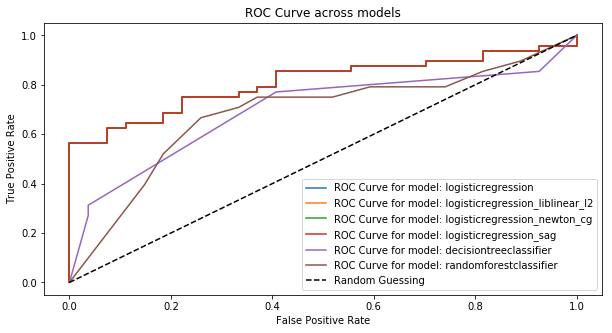

In [35]:

roc_rates = []
model_name = []
for index, key in enumerate(response1):
    
    
    estimator = response1.get(key)
    if estimator.get('roc_auc_score')!=0:
        roc_curve_true_positive_rate = estimator.get('roc_curve_true_positive_rate')
        roc_curve_false_positive_rate = estimator.get('roc_curve_false_positive_rate')
        roc_rates.append([roc_curve_false_positive_rate,roc_curve_true_positive_rate])
        model_name.append(key)

plotROCCurveAcrossModels(roc_rates,model_name) 



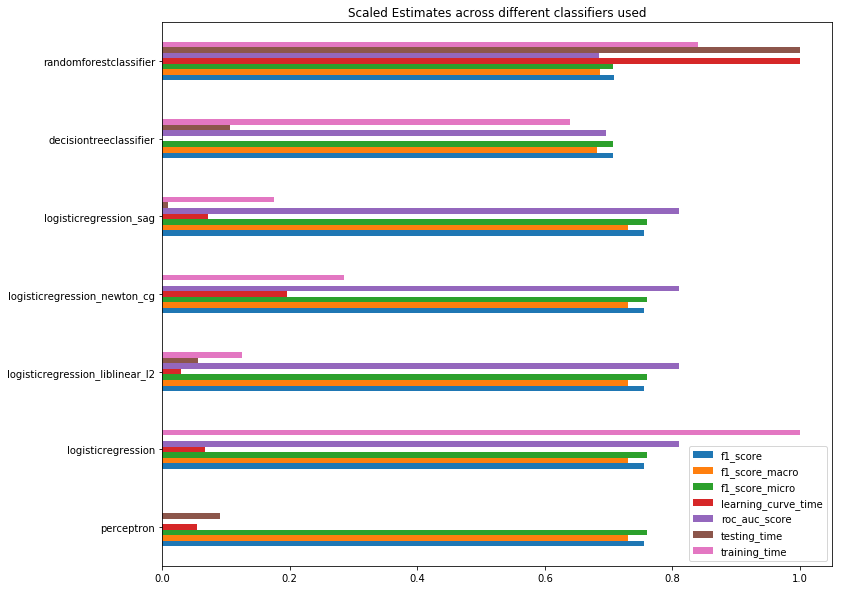

In [36]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_score'] = results['roc_auc_score'].astype('float64')
# results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

### Conclusion:

1. We got highest scores of ROC/AUC 0.92 in logistic regression with l2 parameter

2. From the learning curve, we also see that overfitting tendency is less


In [37]:
test_data = panda.read_csv('data/test.csv')

test_data_x = test_data[[i for i in test_data.columns.tolist() if i not in ['target','id']]]

test_x_lda = lda.transform(test_data_x)

In [40]:
test_target = response1.get('logisticregression').get('best_estimator').predict(test_x_lda)

print(np.bincount(test_target))

final_submission = panda.DataFrame({'target':test_target})
final_submission['id'] = test_data['id']
final_submission[['id','target']].head() 

# np.bincount(test_target)

final_submission[['id','target']].to_csv('sample_submission_lda_with_logistic.csv', index = False)

[ 4017 15733]
